# EJERCICIO 3 - AVANZADO

El fichero hr_train.cvs contiene una tabla sobre los empleados de una empresa. Entre otros incluye informacion de su nivel de satisfaccion, de la ultima evaluacion obtenida, del numero de proyecto en el que se encuentra, del numero medio de horas por semana, del numero de años que lleva en la compañia, si ha tenido o no un accidente en el trabajo, si se ha ido (left) de la compañia, si ha tenido una promocion en los ultimos 5 años, y por ultimo su nivel salarial (descrito como medio, alto o bajo) y el departamento en que se encuentra (sales/technnical ...)

El departamento de RRHH esta solicitando un clasificador que pueda predecir si alguien esta en riesgo de irse de la compañia para poder actuar  proactivamente. 

Notas:
- La columna "left" indica si alguien se ha ido de la compañia, es la "y" del problema y el objetivo de la prediccion.
- Las columnas "sales" y "salary" son alfanumericas. La mayoria de clasificadores (aunque no todos) no trabajn bien con este tipo de variables y requieren valores numericos. Dado el caso dispones de diferentes alternativas: (1) eliminar esas columnas y trabajar con el resto o (2) traducir esas columnas en columnas binarias - por ejemplo si "salary" tiene tres valores eliminar la columna original y sustituirla por tres columnas salary_low, salary_medium, salary_high donde se pondra un 1 en el tipo de salario y un 0 en las otras dos columnas restantes. Lo mismo para "sales", donde se transformara esa columna en tantas columnas como departamentos y un 1 en el departamento en que se encuentre el trabajador. Este es un preproceso muy tipico.


Nota de evaluacion:

En este ejercicio mas que el resultado final (que tambien) se evaluara los pasos y el razonamiento utilizado en cada decision que se toma para la implementacion del modelo. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc

#Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import shap
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [2]:
df=pd.read_csv('../data/hr_train.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.42,0.46,2,150,3,0,1,0,sales,medium
1,0.66,0.77,2,171,2,0,0,0,technical,medium
2,0.55,0.49,5,240,3,0,0,0,technical,high
3,0.22,0.88,4,213,3,1,0,0,technical,medium
4,0.20,0.72,6,224,4,0,1,0,technical,medium


## Preprocesamiento

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10499 entries, 0 to 10498
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     10499 non-null  float64
 1   last_evaluation        10499 non-null  float64
 2   number_project         10499 non-null  int64  
 3   average_montly_hours   10499 non-null  int64  
 4   time_spend_company     10499 non-null  int64  
 5   Work_accident          10499 non-null  int64  
 6   left                   10499 non-null  int64  
 7   promotion_last_5years  10499 non-null  int64  
 8   sales                  10499 non-null  object 
 9   salary                 10499 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 820.4+ KB


In [4]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,10499.000000,10499.000000,10499.000000,10499.000000,10499.000000,10499.000000,10499.000000,10499.000000
mean,0.612683,0.717131,3.808553,201.059815,3.494238,0.144299,0.292885,0.021716
std,0.248578,0.171483,1.230572,49.959332,1.453227,0.351410,0.455108,0.145763
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [5]:
df.salary.value_counts()

salary
low       5104
medium    4515
high       880
Name: count, dtype: int64

In [6]:
df.sales.value_counts()

sales
sales          2935
technical      1890
support        1556
IT              825
product_mng     639
marketing       614
hr              532
RandD           530
accounting      527
management      451
Name: count, dtype: int64

### Balance de Clases

Para iniciar con este ejercicio, empezaremos mirando como estan distribuidas las clases objetivo (Left), la cual representa si alguien se ha ido de la compañia, y en base a esto podemos empezar a trabajar en distintos modelos o tecnicas para balancear las clases en caso tal se encuentren desbalanceadas.

In [7]:
df.left.value_counts()

left
0    7424
1    3075
Name: count, dtype: int64

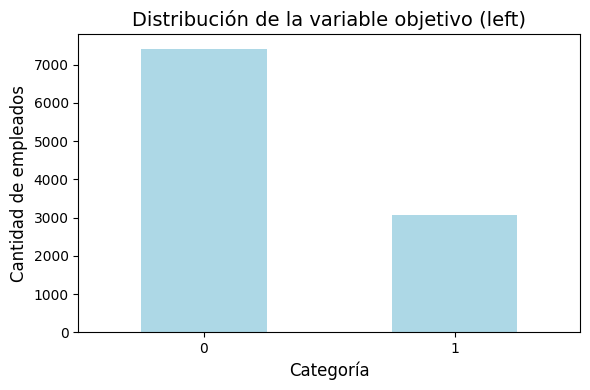

In [8]:
value_counts = df.left.value_counts()

plt.figure(figsize=(6, 4))
value_counts.plot(kind='bar', color='lightblue')
plt.title('Distribución de la variable objetivo (left)', fontsize=14)
plt.xlabel('Categoría', fontsize=12)
plt.ylabel('Cantidad de empleados', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Despues del pequeño analisis podemos concluir que: 
- Clase 0 (no se fue): 7424 empleados ≈ 71%
- Clase 1 (sí se fue): 3075 empleados ≈ 29%

A pesar de que no es un desbalance extremo, las clases si se encuentran un poco desbalanceadas, siendo lo suficientemente significativo como para afectar el rendimiento de los modelos, especialmente si usamos accuracy como métrica principal, es por ende, en los modelos donde la opcion **weight classes** este disponible, la utilizaremos para entrenar los modelos con un balance de clases, y asi obtener resultados postivos. Nuestra metrica principal será **Recall** ya que el obejtivo es detectar a los empleados en riesgo de irse. ademas de F1-score, para tener un balance entre ambas (accuracy y recall).

### Preprocesamiento de las variables categóricas

Para columnas Sales y Salary lo mejor en este caso será aplicarles **One-Hot Encoding** en donde cada categoria se representaria como una columna binaria (0 o 1). De esta manera evitamos suposiciones erróneas de orden o magnitud, por ejemplo, los modelos pueden interpretar mal la relación (El modelo puede pensar que "high" es 2 veces más importante que "low", lo cual no es necesariamente cierto). ademas que cada modelo podrá aprender la relación entre esa categoría y la variable objetivo sin prejuicio por la creacion de "jerarquías" artificiales. De igual manera se preserva toda la información, es decir, la pérdida de esas columnas podría reducir la capacidad del modelo para capturar patrones relevantes, ademas de que, considero que eliminando estas dos columnas estariamos perdiendo mas de lo que podriamos ganar, por eso se tomará esta descicion.



In [9]:
df_encoded = pd.get_dummies(df, columns=["salary", "sales"], drop_first=False)

print("Columnas después del One-Hot Encoding:")
print(df_encoded.columns)

Columnas después del One-Hot Encoding:
Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'salary_high', 'salary_low', 'salary_medium',
       'sales_IT', 'sales_RandD', 'sales_accounting', 'sales_hr',
       'sales_management', 'sales_marketing', 'sales_product_mng',
       'sales_sales', 'sales_support', 'sales_technical'],
      dtype='object')


In [10]:
df_encoded.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary_high,salary_low,...,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical
0,0.42,0.46,2,150,3,0,1,0,False,False,...,False,False,False,False,False,False,False,True,False,False
1,0.66,0.77,2,171,2,0,0,0,False,False,...,False,False,False,False,False,False,False,False,False,True
2,0.55,0.49,5,240,3,0,0,0,True,False,...,False,False,False,False,False,False,False,False,False,True
3,0.22,0.88,4,213,3,1,0,0,False,False,...,False,False,False,False,False,False,False,False,False,True
4,0.20,0.72,6,224,4,0,1,0,False,False,...,False,False,False,False,False,False,False,False,False,True


In [11]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10499 entries, 0 to 10498
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     10499 non-null  float64
 1   last_evaluation        10499 non-null  float64
 2   number_project         10499 non-null  int64  
 3   average_montly_hours   10499 non-null  int64  
 4   time_spend_company     10499 non-null  int64  
 5   Work_accident          10499 non-null  int64  
 6   left                   10499 non-null  int64  
 7   promotion_last_5years  10499 non-null  int64  
 8   salary_high            10499 non-null  bool   
 9   salary_low             10499 non-null  bool   
 10  salary_medium          10499 non-null  bool   
 11  sales_IT               10499 non-null  bool   
 12  sales_RandD            10499 non-null  bool   
 13  sales_accounting       10499 non-null  bool   
 14  sales_hr               10499 non-null  bool   
 15  sa

### Validación de los resultados

- salary: ahora tenemos tres columnas (high, low, medium)

- sales: cada departamento se representa como una columna (IT, RandD, hr, etc)

**Nota:** ya que todas las columnas están codificadas como booleanas (True/False), la mayoria de los modelos no trabajan directamente con booleanos, asi que vamos a convertir esos valores a enteros 0 y 1.

In [12]:
df_encoded = df_encoded.astype({col: int for col in df_encoded.select_dtypes("bool").columns})

In [13]:
df_encoded.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary_high,salary_low,...,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical
0,0.42,0.46,2,150,3,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.66,0.77,2,171,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.55,0.49,5,240,3,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0.22,0.88,4,213,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.20,0.72,6,224,4,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Graficos que se utilizarán

In [14]:
def plot_confusion_matrix(y_test, y_pred, title="Matriz de Confusión"):
    plt.figure(figsize=(10, 6))
    labels=["Se queda", "Se va"]
    cf_mtx_rf = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_mtx_rf, display_labels=labels)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [15]:
def plot_roc_curve(y_true, y_proba, title="Curva ROC"):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.02])
    plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

### Separación de variables predictoras (X) y objetivo (y)

In [16]:
y = df_encoded["left"] # Variable objetivo

X = df_encoded.drop("left", axis=1) # Variables predictoras

### Division y Escalado de los datos 

Usaremos el stratify, debido a que preserva la proporción original de clases (left = 0 y left = 1) tanto en el conjunto de entrenamiento como en el de prueba, ya que existe un desbalance de clases. Si usamos un train_test_split sin stratify, podríamos acabar con un conjunto de entrenamiento que no representa bien el problema (por ejemplo, con muy pocos casos de empleados que se fueron).

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### SHAP (SHapley Additive exPlanations)
Esto es algo adicional, que estuve investigando y me parecio interesante probarlo en este ejercicio. Es una técnica de interpretabilidad de modelos de machine learning basada en la teoría de juegos. SHAP calcula cuánto contribuye cada variable a cada predicción hecha por el modelo. Dado que algunos de los modelos que usaré a continuacion como MLPClassifier o SVM son modelos muy potentes, pero su desventaja es que no ofrecen directamente medidas claras de importancia por variable como otros modelos (Arboles o Gradient Boosting). Por eso, decidí usar SHAP, ya que esta me que permite entender cómo influye cada variable en cada predicción, incluso para modelos complejos. Esto me puede servir de mucho al momento de explicar por qué un empleado fue clasificado como en riesgo, y qué factores específicos influyeron más. Mi objetivo principal con esto es: 
- Ver qué variables son las mas importantes globalmente, sin importar el modelo.

In [19]:
X_background = shap.utils.sample(X_train_scaled, 100, random_state=42)

In [20]:
X_test_sample = X_test_scaled[:100]

X_test_sample_df = pd.DataFrame(X_test_sample, columns=X.columns)

Este explainer tomará algunas muestras de entrenamiento para usar como "fondo" y luego calculará el impacto de cada variable sobre la predicción. En cada modelo que lo requiera, se explicará brevemente su funcionamiento y utilidad.

## Modelos 

### Regresion Logistica 
El primer modelo que utilizaremos sea una regresion logistica simplemente como un avance rapido (como de guia), ya que es simple, rápido de entrenar y muy fácil de interpretar. Servirá como punto de comparación para modelos más complejos como Random Forest o MLP. Sera algo sencillo ya que no necesita grandes cantidades de ajuste ni una arquitectura complicada. Unicamente será de prueba

In [21]:
logreg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000) #Se usa el weight classes para mantener las clases balanceadas
logreg.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [22]:
y_pred_lg = logreg.predict(X_test_scaled)
y_proba_lg = logreg.predict_proba(X_test_scaled)[:, 1]

In [23]:
print("Reporte de Clasificación Regresion Logistica:")
print(classification_report(y_test, y_pred_lg))

Reporte de Clasificación Regresion Logistica:
              precision    recall  f1-score   support

           0       0.83      0.68      0.74      1485
           1       0.46      0.66      0.54       615

    accuracy                           0.67      2100
   macro avg       0.64      0.67      0.64      2100
weighted avg       0.72      0.67      0.68      2100



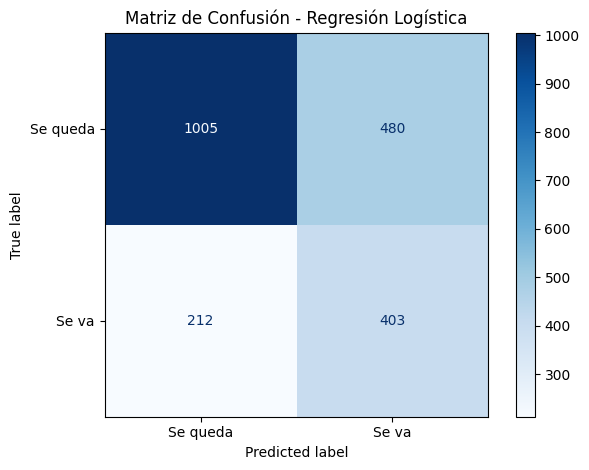

In [24]:
plot_confusion_matrix(y_test, y_pred_lg, title="Matriz de Confusión - Regresión Logística")

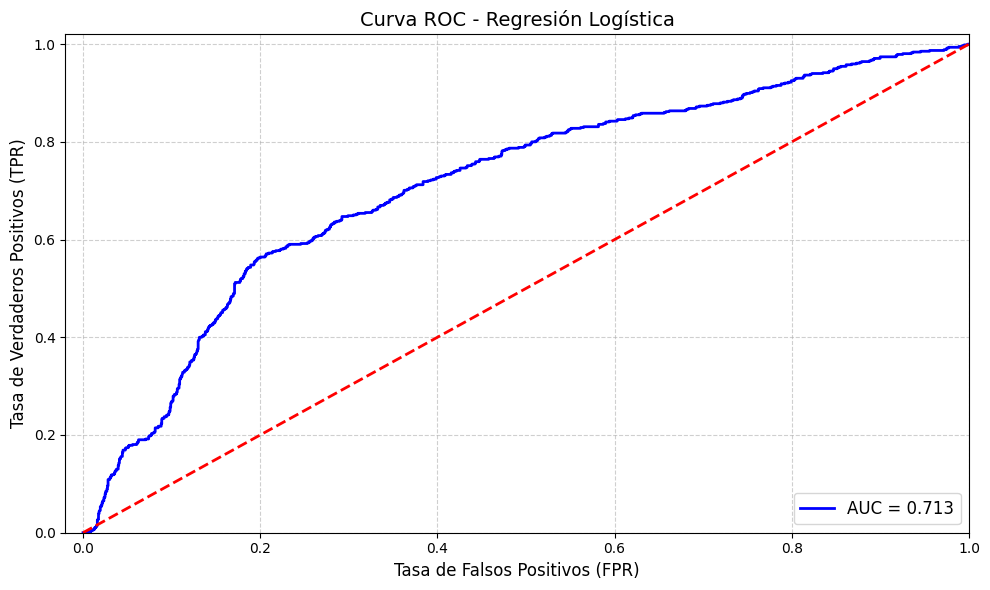

In [25]:
plot_roc_curve(y_test, y_proba_lg, title="Curva ROC - Regresión Logística")

In [26]:
print("AUC-ROC Score:", roc_auc_score(y_test, y_proba_lg)*100)

AUC-ROC Score: 71.307766006953


#### Análisis Regresión Logística
El modelo detecta correctamente el 66% de las salidas reales (recall de la clase 1). Sin embargo, comete muchos falsos positivos: 480 empleados clasificados erroneamente como que se van, lo cual llega a ser muy problematico para llegar a tomar decisiones.

**Capacidades del modelo**

Fortalezas:

- Buen recall para la clase minoritaria (66%).

- Modelo simple y facil de entrenar.

Debilidades:

- Precision muy baja (0.46): casi la mitad de los empleados que se predicen como "se va" no lo hacen realmente.

- Genera muchos falsos positivos, lo cual no es nuestro objetivo.

- F1-score de 0.54 para "Se va", por debajo de lo aceptable para este caso.

**Conclusion**

La regresión logística, a pesar de ser un modelo base útil para comparación, no ofrece un rendimiento competitivo frente a modelos más complejos. Su bajo F1-score y AUC solo moderado indican que no es adecuado como modelo final si se desea intervenir con precisión a quienes están en riesgo de abandonar la empresa. **Descartado** totalemente.

### Random Forest
La idea principal de uso de Random Forest es su robustez y rendimiento,ya que al construir multiples árboles y promediar sus predicciones, ofrece un rendimiento sólido, mientras que la regresion logistica asume relaciones lineales entre las variables y la salida, Random Forest puede modelar relaciones no lineales y complejas, como por ejemplo:

- “Empleados con baja satisfacción y alto número de proyectos tienen mayor probabilidad de irse”.

Ademas de algo que me parece su mejor caracteristica, Random Forest permite obtener la importancia de cada variable, algo fundamentalal momento de tomar decisiones, por ejemplo. En este caso se le podria decir a los de RRHH:

- ¿Qué influye más en la decisión de irse? ¿Satisfacción? ¿Horas trabajadas? ¿Departamento?

Esto hace que el modelo no solo sea predictivo, sino también diagnostico que podamos hacerle a nuestro problema.

In [27]:
rf_model = RandomForestClassifier(class_weight='balanced',random_state=42) #Se usa el weight classes para mantener las clases balanceadas
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]  # Para ROC AUC

In [28]:
print("Reporte de Clasificación - Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=["Se queda", "Se va"]))

Reporte de Clasificación - Random Forest:
              precision    recall  f1-score   support

    Se queda       0.87      0.96      0.91      1485
       Se va       0.86      0.64      0.73       615

    accuracy                           0.86      2100
   macro avg       0.86      0.80      0.82      2100
weighted avg       0.86      0.86      0.86      2100



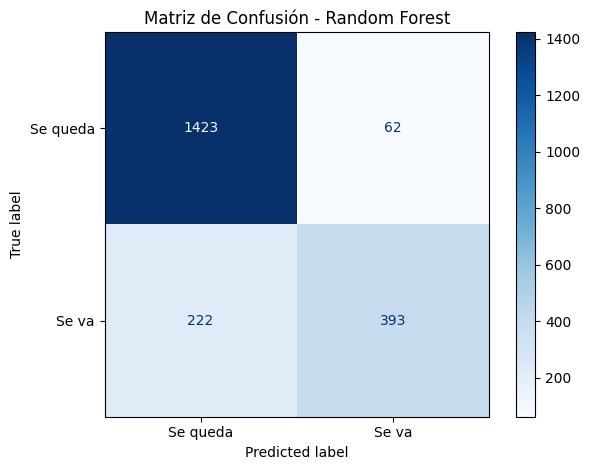

In [29]:
plot_confusion_matrix(y_test, y_pred_rf, title="Matriz de Confusión - Random Forest")

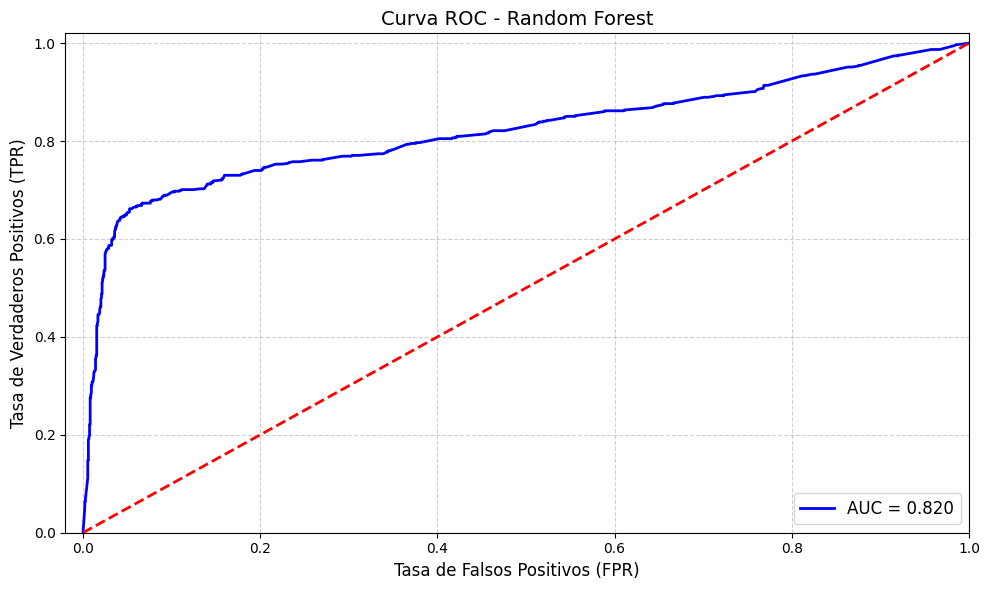

Roc-score: 82.01593167446826


In [30]:
plot_roc_curve(y_test, y_proba_rf, title="Curva ROC - Random Forest")
print(f"Roc-score: {roc_auc_score(y_test, y_proba_rf)*100}")

In [31]:
importances = rf_model.feature_importances_
features = X_train.columns
feat_imp_df = pd.DataFrame({'feature': features, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False) 

print(feat_imp_df.head(10))

                 feature  importance
0     satisfaction_level    0.250260
3   average_montly_hours    0.198186
1        last_evaluation    0.159739
4     time_spend_company    0.146652
2         number_project    0.119769
5          Work_accident    0.015220
17           sales_sales    0.012399
19       sales_technical    0.011166
8             salary_low    0.011129
18         sales_support    0.009834


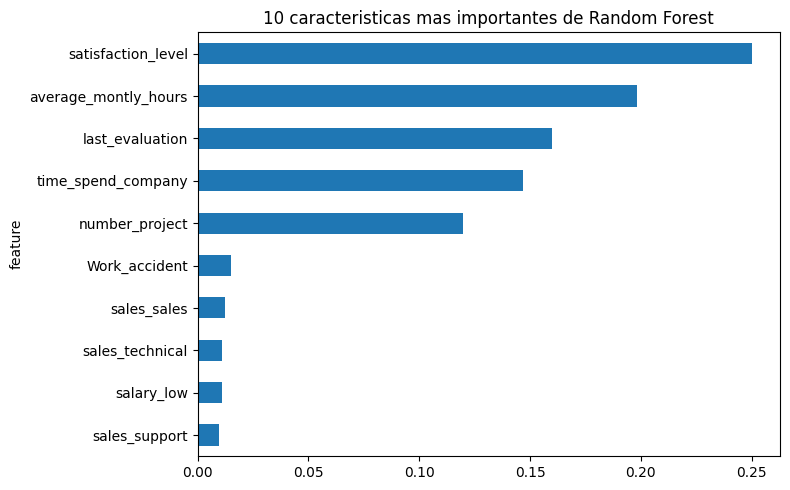

In [83]:
feat_imp_df.head(10).plot(kind='barh', x='feature', y='importance', legend=False, figsize=(8,5))
plt.title("10 caracteristicas mas importantes de Random Forest")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Análisis Random Forest 
El modelo presenta un muy bajo numero de falsos positivos (solo 62), lo cual es ideal en nuestro problema. Aunque no alcanza el recall muy alto en “se va” (64%), logra mantener un buen equilibrio entre precisión (86%) y f1-score (0.73) para esa clase. Tambien el **AUC** de 0.82 indica un alto poder discriminativo del modelo.

**Importancia de características**

Segun el grafico de importancia del modelo:

1. satisfaction_level es la variable más importante (≈ 25%)

2. Le siguen average_monthly_hours, last_evaluation, time_spend_company, y number_project.

3. Las variables relacionadas con salario o departamento tienen menor relevancia para este modelo pero de igual manera estan en el top 10 las caracteristicas mas importantes.

**Capacidades del modelo**

Fortalezas:

- Alta precisión y exactitud general (86%).

- Muy buen rendimiento en “se queda” y aceptable en “se va”.

- Bajo numero de falsos positivos, ideal en este contexto.

- Explicable por importancia de variables.

Debilidades:

- Aunque el recall de “se va” es aceptable (64%), hay 222 casos de empleados que efectivamente se fueron pero no fueron detectados.

**Conclusion**
Random Forest demuestra ser un modelo robusto, con excelente rendimiento global y comportamiento equilibrado entre ambas clases. Seria interesante usarlo cuando se busca minimizar falsos positivos, y se tiene una tolerancia aceptable al número de salidas no detectadas. Yo diria que su interpretabilidad se basa principalmente en importancia de características lo cual lo hace práctico para análisis generales, aunque limitado a nivel individual.

### SVM

Excelente rendimiento en clases desbalanceadas (como es nuestro caso), usaremos SVM con class_weight='balanced' ya que esto ajusta automáticamente el peso de cada clase. Nos podra ser muy útil cuando queremos maximizar recall de la clase 1 (quien se va), lo cual es nuestro caso, ademas que, tras el One-Hot Encoding, ahora tenemos mas de 19 variables y sabemos que SVM trabaja muy bien en este tipo de entornos, especialmente con el kernel RBF (no lineal). Tambien con este kernel podemos capturar relaciones o patrones no lineales entre variables como:

- Satisfacción + carga de trabajo + departamento = riesgo de salida

En general, SVM  es un modelo que puede ser util para este ejercicio ya que funciona muy bien para detectar patrones sutiles y no lineales, en este caso es ideal ya que necesitamos precisión y control en casos sensibles, en especial al decidir si un empleado se irá o no.

In [33]:
svm_model = SVC(kernel='rbf',class_weight='balanced',probability=True,random_state=42) #Se usa el weight classes para mantener las clases balanceadas
svm_model.fit(X_train_scaled, y_train)

# Predicciones
y_pred_svm = svm_model.predict(X_test_scaled)
y_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

In [34]:
print("Reporte de Clasificación - SVM:")
print(classification_report(y_test, y_pred_svm, target_names=["Se queda", "Se va"]))

Reporte de Clasificación - SVM:
              precision    recall  f1-score   support

    Se queda       0.87      0.92      0.89      1485
       Se va       0.77      0.67      0.72       615

    accuracy                           0.84      2100
   macro avg       0.82      0.79      0.80      2100
weighted avg       0.84      0.84      0.84      2100



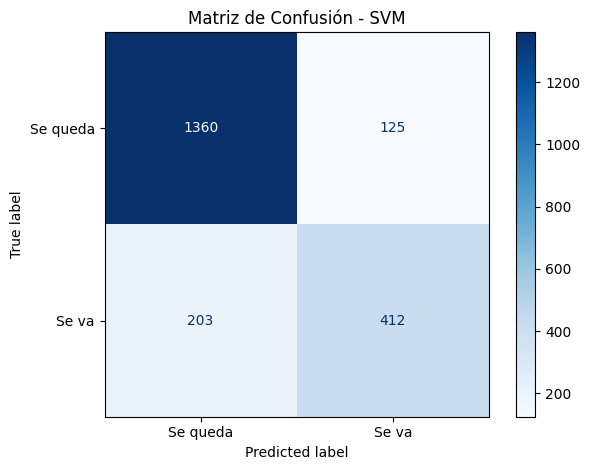

In [35]:
plot_confusion_matrix(y_test, y_pred_svm, title="Matriz de Confusión - SVM")

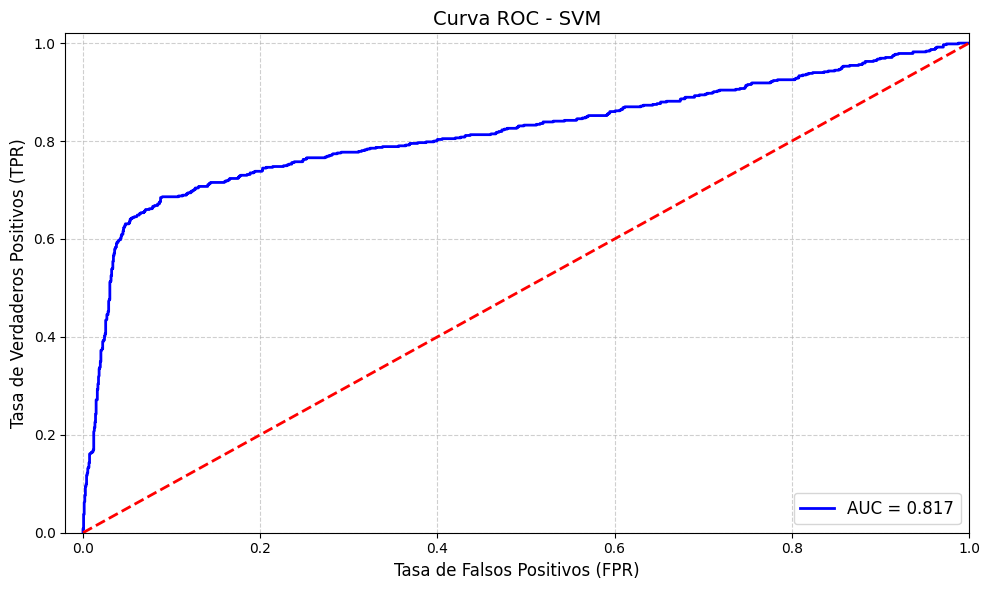

AUC-Score: 81.70299197941475


In [86]:
plot_roc_curve(y_test, y_proba_svm, title="Curva ROC - SVM")
print(f"AUC-Score: {roc_auc_score(y_test, y_proba_svm)*100}")

In [37]:
explainer = shap.KernelExplainer(svm_model.predict, X_background)

In [38]:
shap_values_svm = explainer.shap_values(X_test_sample)

  0%|          | 0/100 [00:00<?, ?it/s]

In [39]:
mean_abs_shap_svm = np.abs(shap_values_svm).mean(axis=0)
top_10_idx_svm = np.argsort(mean_abs_shap_svm)[-10:]

shap_explanation_svm_top10 = shap.Explanation(
    values=shap_values_svm[:, top_10_idx_svm],
    data=X_test_sample_df.values[:, top_10_idx_svm],
    feature_names=[X.columns[i] for i in top_10_idx_svm]
)

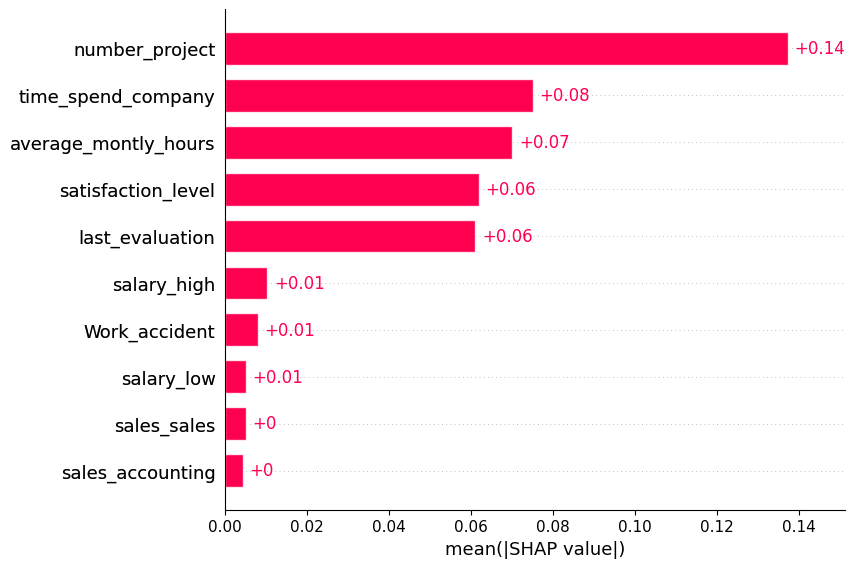

In [73]:
shap.plots.bar(shap_explanation_svm_top10)

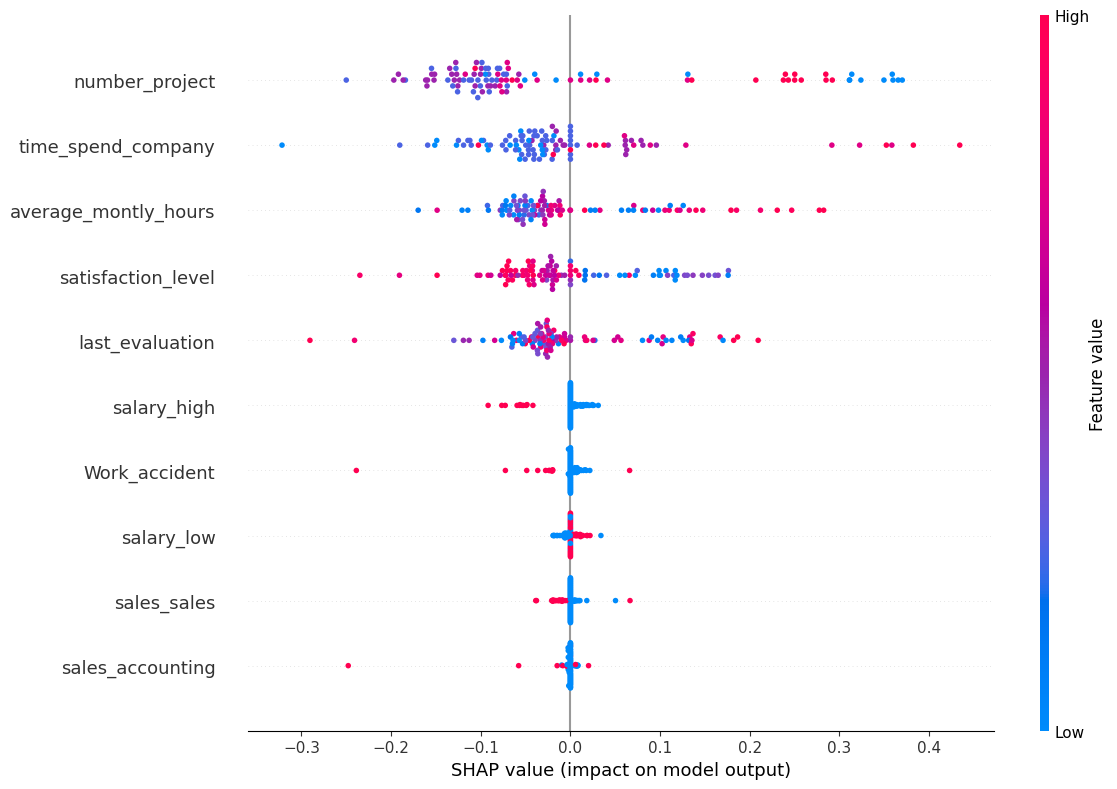

In [42]:
shap_values_top10_svm = shap_values_svm[:, top_10_idx_svm]
X_test_sample_df_top10 = X_test_sample_df.iloc[:, top_10_idx_svm]

shap.summary_plot(
    shap_values_top10_svm,
    X_test_sample_df_top10,
    plot_type="dot",      
    max_display=10, 
    plot_size=[12,8],
)

Aca hay que tener una cosa en cuenta que es muy importante, cada punto representa una predicción, es decir, un empleado. Los valores en el eje de las "X" representan cuanto esa variable empuja la predicción hacia que el empleado se vaya (valores positivos) o se quede (valores negativos). Este tipo de visualizaciones permite conocer cuales variables son importantes, ademas de darnos una idea sobre cómo afectan las decisiones individuales del modelo, lo que da lugar a explicaciones mucho mas complejas

#### Análisis SVM
El modelo logra detectar 67% de los empleados que efectivamente se van, lo que es ligeramente mejor que Random Forest en esta clase.
Además, mantiene un buen control de falsos positivos, con solo 125 casos. El modelo tambien presenta un **AUC** de 0.817  que indica una excelente capacidad discriminativa, muy cercana al rendimiento de Random Forest (0.82).

**Interpretabilidad con SHAP**

A diferencia de Random Forest, el modelo SVM fue interpretado usando SHAP, lo cual permite entender como cada variable influye en cada predicción individual.

Variables más influyentes (SHAP bar plot):

- number_project

- time_spend_company

- average_monthly_hours

- satisfaction_level

- last_evaluation

Podemos observar que algunas coinciden con las de Random Forest (satisfaction_level, average_monthly_hours, last_evaluation, time_spend_company, y number_project) lo cual indica un muy buen indicio.

SHAP summary plot:

- Las variables como number_project y satisfaction_level tienen un impacto positivo o negativo en la decisión según su valor, lo cual hay que tener en cuenta.

- Se observa que valores altos o bajos extremos en estas variables tienden a influir en predicciones de salida.

**Capacidades del modelo**

Fortalezas:

- Muy buen equilibrio entre precisión (77%) y recall (67%) en clase “se va”.

- Excelente exactitud general (84%).

- Capacidad explicativa por medio de SHAP, útil para explicaciones individuales.

- Buen manejo del sesgo entre clases.

Debilidades:

- Ligeramente más costoso computacionalmente.

- Algo más sensible a la escala de los datos (ya que se requiere normalización).

**Conclusion**

SVM se presenta como un modelo altamente competitivo, con un balance solido entre rendimiento y explicabilidad. Es especialmente adecuado si no solo queremos predecir salidas con buena precisión, sino también entender por qué un empleado está en riesgo de irse, gracias al uso de SHAP.A pesar de que SHAP es algo que agregue por mi cuenta siento que puede llegar a ser muy util en este caso para entender mejor el funcionamiento de los modelos.

### MLP

Tambien usaremos un MLP ya que estos modelos aprenden relaciones complejas y no lineales a diferencia de modelos como regresión logística, un MLP puede aprender funciones altamente no lineales. Tambien que captura interacciones ocultas entre variables, como combinaciones entre satisfacción, número de proyectos, horas y salario. Ademas de la gran flexibilidad de este tiene, ya que permite modificar sus hiperparametros, esto permite afinar el modelo según el comportamiento real en base a los datos. En resumen esperemos que el MLP sea una buena opción para que pueda modelar el problema problema, ya que como lo dije anteriormente, este puede beneficiarse de alta capacidad de representación y flexibilidad en el modelado. Tambien se utilizará la tecnica de GridSearchCV. Con el fin explorar diferentes numeros de neuronas en cada capa. En este ejemplo voy a evaluar diversas configuraciones con el fin de encontrar la mejor, y se utilizarán 10 folds para la validacion cruzada.

In [43]:
param_grid = {
    "hidden_layer_sizes": [
        (5,),       
        (10,),       
        (15,),       
        (5, 5),     
        (10, 5),
        (10, 10),
        (20, 20),
        (30, 30),
        (50, 50),
        (100, 100),
        (50, 25),  
        (100, 50),
        (30, 20),
        (20, 10)
    ]
}

In [44]:
mlp = MLPClassifier(max_iter=10000, random_state=42)

In [45]:
grid_search_mlp = GridSearchCV(estimator=mlp,param_grid=param_grid,scoring='recall',cv=10,return_train_score=True,verbose=True,n_jobs=-1)

In [46]:
grid_search_mlp.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


GridSearchCV(cv=10, estimator=MLPClassifier(max_iter=10000, random_state=42),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(5,), (10,), (15,), (5, 5),
                                                (10, 5), (10, 10), (20, 20),
                                                (30, 30), (50, 50), (100, 100),
                                                (50, 25), (100, 50), (30, 20),
                                                (20, 10)]},
             return_train_score=True, scoring='recall', verbose=True)

In [47]:
results_mlp = pd.DataFrame(grid_search_mlp.cv_results_)
print(results_mlp[['param_hidden_layer_sizes', 'mean_test_score', 'std_test_score']])

   param_hidden_layer_sizes  mean_test_score  std_test_score
0                      (5,)         0.654472        0.020887
1                     (10,)         0.673577        0.028804
2                     (15,)         0.667480        0.028502
3                    (5, 5)         0.670325        0.023242
4                   (10, 5)         0.662602        0.026842
5                  (10, 10)         0.667886        0.028862
6                  (20, 20)         0.665041        0.028234
7                  (30, 30)         0.686179        0.029415
8                  (50, 50)         0.687805        0.033114
9                (100, 100)         0.686992        0.029982
10                 (50, 25)         0.683740        0.024979
11                (100, 50)         0.685366        0.040332
12                 (30, 20)         0.675203        0.029056
13                 (20, 10)         0.669512        0.029875


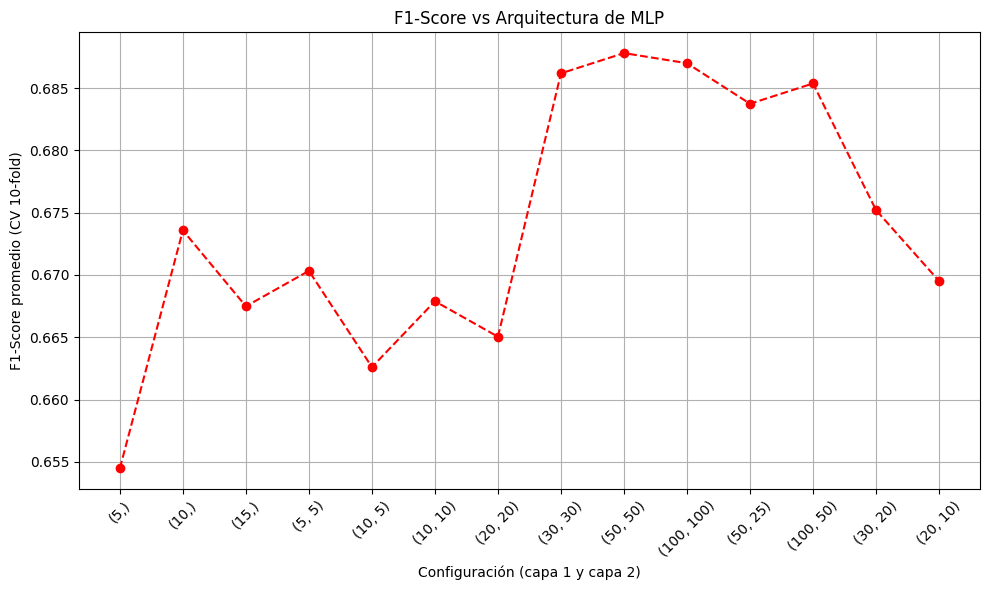

Mejor configuración: {'hidden_layer_sizes': (50, 50)}
Mejor recall promedio: 0.6878048780487805


In [48]:
plt.figure(figsize=(10, 6))
plt.plot(results_mlp['param_hidden_layer_sizes'].astype(str),
         results_mlp['mean_test_score'], marker='o', linestyle='--', color='red')
plt.xlabel("Configuración (capa 1 y capa 2)")
plt.ylabel("F1-Score promedio (CV 10-fold)")
plt.title("F1-Score vs Arquitectura de MLP")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

best_hidden_ly = grid_search_mlp.best_params_
print("Mejor configuración:", best_hidden_ly)
print("Mejor recall promedio:", grid_search_mlp.best_score_)

Listo, ahora que encontramos la mejor configuracion de arquitectura para la red, pasaremos a entrenarla y a evaluar sus metricas

In [49]:
final_mlp = MLPClassifier(
    hidden_layer_sizes=best_hidden_ly['hidden_layer_sizes'],
    max_iter=10000,
    random_state=42
)
final_mlp.fit(X_train_scaled, y_train)

y_pred_mlp = final_mlp.predict(X_test_scaled)
y_proba_mlp = final_mlp.predict_proba(X_test_scaled)[:, 1]

In [50]:
print("Reporte de Clasificación MLP:\n", classification_report(y_test, y_pred_mlp))

Reporte de Clasificación MLP:
               precision    recall  f1-score   support

           0       0.87      0.90      0.88      1485
           1       0.74      0.67      0.70       615

    accuracy                           0.83      2100
   macro avg       0.80      0.79      0.79      2100
weighted avg       0.83      0.83      0.83      2100



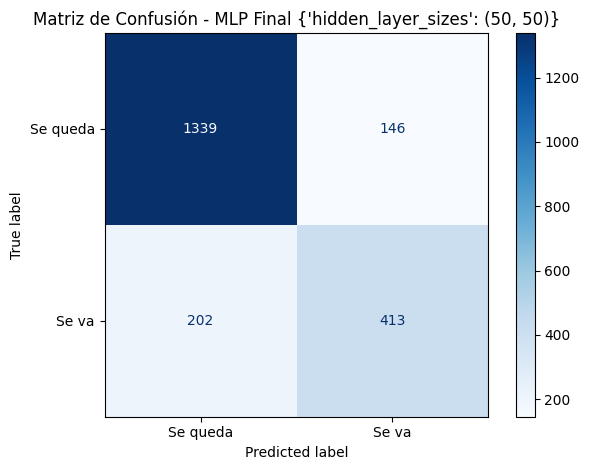

In [51]:
plot_confusion_matrix(y_test, y_pred_mlp, title=f"Matriz de Confusión - MLP Final {best_hidden_ly}")

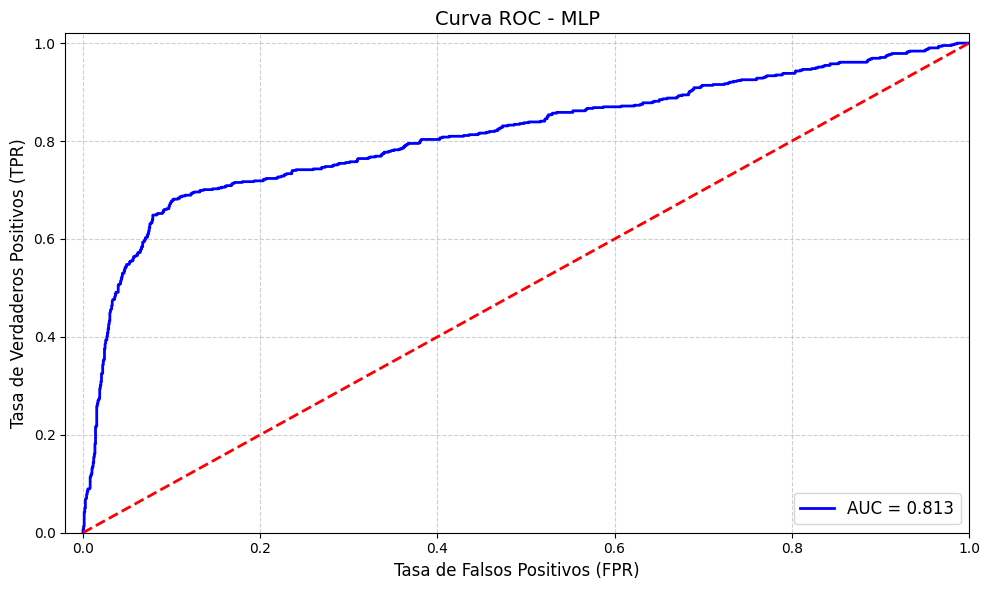

AUC-score: 81.25931400728149


In [87]:
plot_roc_curve(y_test, y_proba_mlp, title="Curva ROC - MLP")
print(f"AUC-score: {roc_auc_score(y_test, y_proba_mlp)*100}")

In [53]:
explainer_mlp = shap.KernelExplainer(final_mlp.predict, X_background)

In [54]:
shap_values_mlp = explainer_mlp.shap_values(X_test_sample)

  0%|          | 0/100 [00:00<?, ?it/s]

In [55]:
mean_abs_shap_mlp = np.abs(shap_values_mlp).mean(axis=0)
top_10_idx_mlp = np.argsort(mean_abs_shap_mlp)[-10:]

In [56]:
shap_explanation_mlp_top10 = shap.Explanation(
    values=shap_values_mlp[:, top_10_idx_mlp],
    data=X_test_sample_df.values[:, top_10_idx_mlp],
    feature_names=[X.columns[i] for i in top_10_idx_mlp]
)

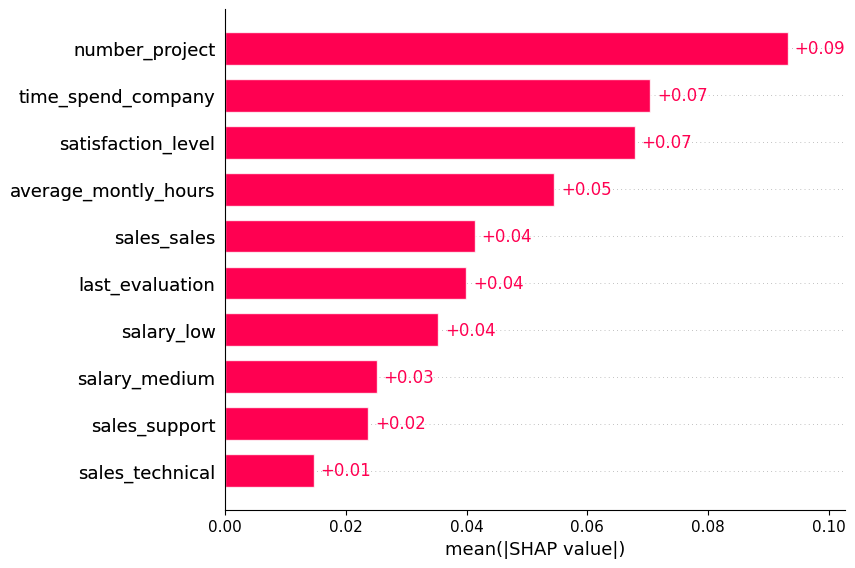

In [57]:
shap.plots.bar(shap_explanation_mlp_top10)

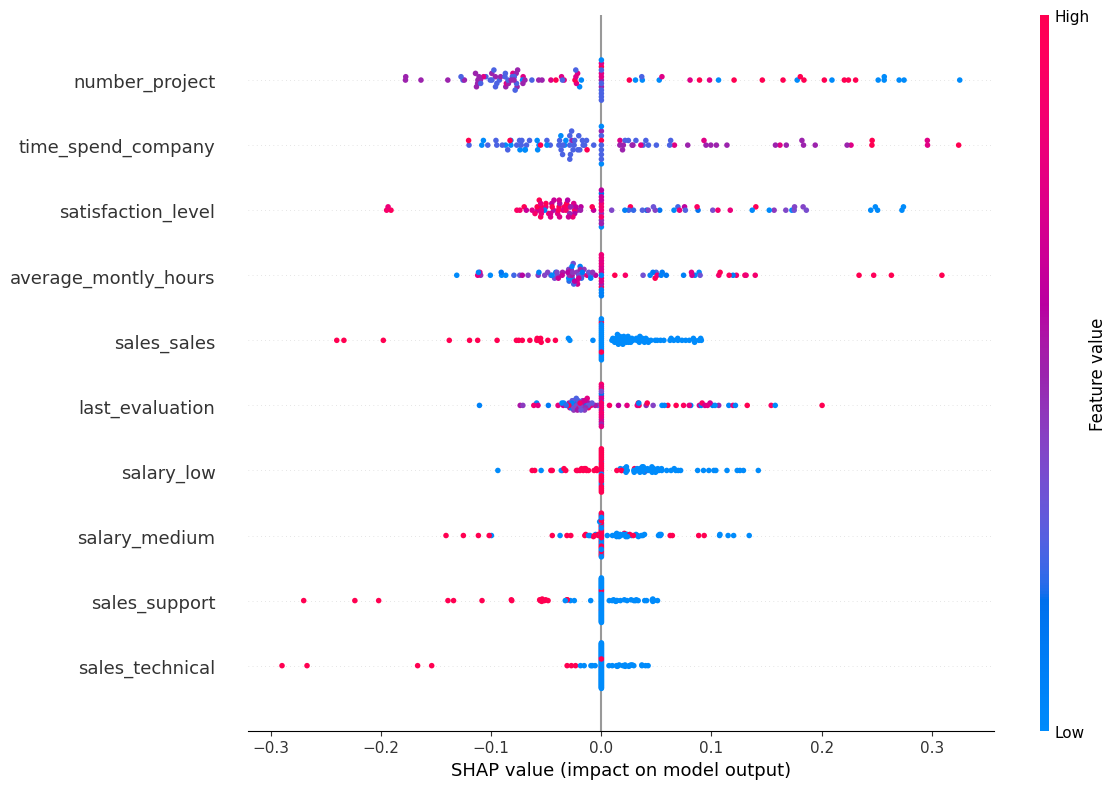

In [59]:
shap_values_top10_mlp = shap_values_mlp[:, top_10_idx_mlp]
X_test_sample_df_top10 = X_test_sample_df.iloc[:, top_10_idx_mlp]

shap.summary_plot(
    shap_values_top10_mlp,
    X_test_sample_df_top10,
    plot_type="dot",      
    max_display=10, 
    plot_size=[12,8],
)

#### Análisis MLP 
El modelo logra detectar el 67% de los casos reales de empleados que se van, valor similar al alcanzado por SVM. Su precisión del 74% para la clase positiva significa que, cuando predice que alguien se va, lo hace con buen nivel de confianza. El **AUC** del modelo es de 0.813 es alto, indicando buena capacidad de discriminación entre clases.

**Interpretabilidad con SHAP**

Al igual que en SVM, se utilizó SHAP para interpretar el modelo, lo cual es especialmente útil en este tipo de modelos, donde la interpretabilidad no suele ser tan sencilla de apreciar.

Variables más influyentes según SHAP:

- number_project

- time_spend_company

- satisfaction_level

- average_monthly_hours

- sales_sales

Estas características son muy consistentes con lo observado en los otros modelos, lo que aporta robustez y validez cruzada al análisis.

SHAP summary plot:

Las variables con mayor dispersión en los valores SHAP tienen mayor impacto. Se observan patrones como:

- Empleados con muchos proyectos y alta permanencia tienden a estar más en riesgo.

- Bajos niveles de satisfacción también son clave en las decisiones del modelo.

**Capacidades del modelo**

Fortalezas:

- Buen desempeño general con accuracy de 83% y f1-score de 0.70 para la clase “se va”.

- Buena capacidad de generalización evidenciada por el AUC.

- Explicabilidad garantizada mediante SHAP, lo que habilita nos permite hacer interpretaciones útiles.

- Capacidad para capturar relaciones no lineales complejas entre variables.

Debilidades:

- Ligera caída en recall (67%) comparado con Random Forest en términos absolutos.

- Dependencia de un buen preprocesamiento y escalado de datos.

**Conclusion**

MLP se presenta como un modelo robusto y muy interesante, con interpretabilidad añadida gracias a SHAP. Su combinación de precisión razonable, buena generalización y capacidad de modelar relaciones complejas lo hace una opción potente y flexible para el problema del riesgo de salida y otros problemas relacionados, es un modelo a tener en cuenta.

### Gradient Boosting Classifier
Como ultimo modelo probaremos el Gradient Boosting Classifier ya que es uno de metodos que mejores resultados tiene, ademas como MLP o Random Forest, puede encontrar patrones difíciles de ver en los datos. En este caso será útil para encontrar interacciones entre variables, como en el comportamiento de los empleados. Tambien que como estamos buscando un modelo de alta precisión, no lineal, ajustable y robusto, es una opcion a tener en cuenta para este ejercicio. Nuevamente de usará un Grid Search CV para hallar la mejor configuracion del learning rate para el modelo, ademas se mantendran los mismos 10 folds para la validacion cruzada.

In [60]:
param_grid = {
    'learning_rate': [ 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
}
gb_model = GradientBoostingClassifier(random_state=42)

grid_search_gb = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    scoring='recall',
    cv=10,
    verbose=2,
    n_jobs=-1
)

In [61]:
grid_search_gb.fit(X_train, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]},
             scoring='recall', verbose=2)

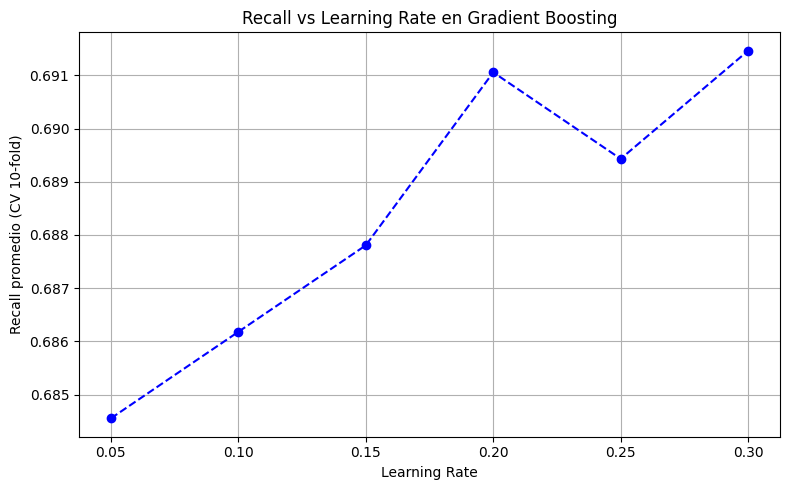

Mejor learning_rate: {'learning_rate': 0.3}
Mejor recall promedio: 0.6914634146341464


In [62]:
results_lr = pd.DataFrame(grid_search_gb.cv_results_)

plt.figure(figsize=(8, 5))
plt.plot(results_lr['param_learning_rate'], results_lr['mean_test_score'],
         marker='o', linestyle='--', color='blue')
plt.xlabel("Learning Rate")
plt.ylabel("Recall promedio (CV 10-fold)")
plt.title("Recall vs Learning Rate en Gradient Boosting")
plt.grid(True)
plt.tight_layout()
plt.show()


best_lr = grid_search_gb.best_params_
print("Mejor learning_rate:", best_lr)
print("Mejor recall promedio:", grid_search_gb.best_score_)

In [63]:
final_gb = GradientBoostingClassifier(
    learning_rate=best_lr['learning_rate'],
    random_state=42
)
final_gb.fit(X_train, y_train)

y_pred_gb = final_gb.predict(X_test)
y_proba_gb = final_gb.predict_proba(X_test)[:, 1]

In [71]:
print("Reporte de Clasificación Gradient Boosting:\n", classification_report(y_test, y_pred_gb))

Reporte de Clasificación Gradient Boosting:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91      1485
           1       0.86      0.65      0.74       615

    accuracy                           0.87      2100
   macro avg       0.86      0.80      0.82      2100
weighted avg       0.86      0.87      0.86      2100



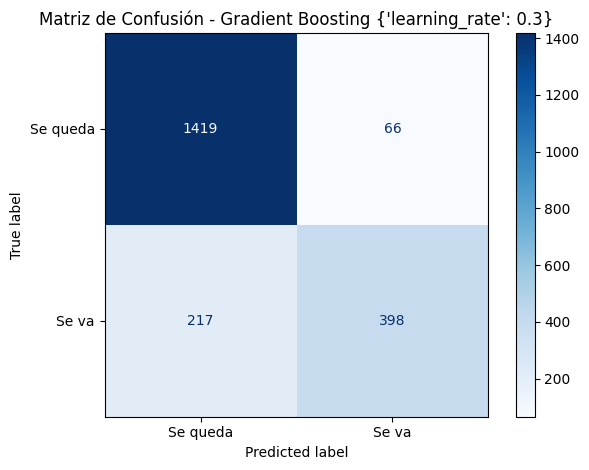

In [70]:
plot_confusion_matrix(y_test, y_pred_gb, title=f"Matriz de Confusión - Gradient Boosting {best_lr}")

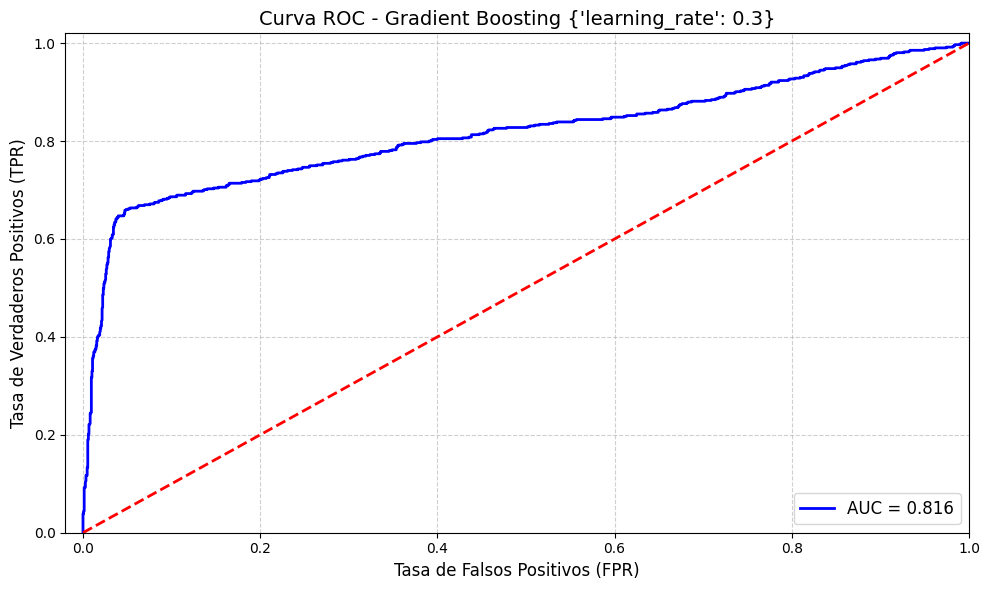

AUC-score: 81.59508362760396


In [88]:
plot_roc_curve(y_test, y_proba_gb, title=f"Curva ROC - Gradient Boosting {best_lr}")
print(f"AUC-score: {roc_auc_score(y_test, y_proba_gb)*100}")

In [66]:
importances_gb = final_gb.feature_importances_
features = X_train.columns
feat_imp_gb_df = pd.DataFrame({'feature': features,'importance': importances_gb}).sort_values(by='importance', ascending=False)

print(feat_imp_gb_df.head(10))

                 feature  importance
0     satisfaction_level    0.501980
4     time_spend_company    0.170612
3   average_montly_hours    0.108967
1        last_evaluation    0.101078
2         number_project    0.097382
5          Work_accident    0.002960
16     sales_product_mng    0.002830
7            salary_high    0.002457
19       sales_technical    0.001878
18         sales_support    0.001670


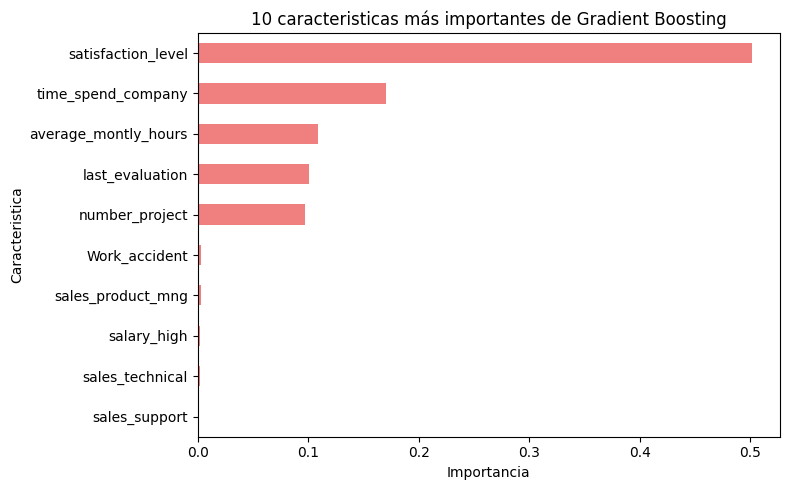

In [89]:
feat_imp_gb_df.head(10).plot(kind='barh',x='feature',y='importance',legend=False,figsize=(8, 5),color='lightcoral')
plt.title("10 caracteristicas más importantes de Gradient Boosting")
plt.xlabel("Importancia")
plt.ylabel("Caracteristica")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Análisis Gradient Boosting 
Este modelo mantiene un buen balance general en la clasificación, con un alto desempeño especialmente en la clase mayoritaria ("Se queda"). Aunque el modelo tiene una ligera tendencia a predecir que los empleados se quedan, logra recuperar un 65% de los que realmente se van (recall clase 1), lo cual es valioso en este contexto donde queremos prevenir las salidas. El modelo cuenta con un  **AUC** de 0.816, lo cual indica que el modelo tiene una alta capacidad para separar las clases y demuestra un buen poder discriminativo.

**importancia de características**

Según la gráfica de importancia de características de este modelo, las variables mas influyentes son:
 
- satisfaction_level	
- time_spend_company	
- average_monthly_hours	
- last_evaluation	
- number_project	

Nos demuestra que la variable satisfaction_level destaca significativamente sobre el resto con una importancia del 50%. Esto indica que el nivel de satisfacción del empleado es el factor más determinante en la predicción del modelo.

**Capacidades del modelo**

Fortalezas:

- Alto accuracy (87%) y buen balance entre precision y recall.

- Excelente desempeño para detectar la clase "Se queda" (recall 0.96).

- Buen AUC (0.816), indicando fuerte capacidad predictiva.

- Importancia de variables coherente con los otros modelos: la satisfacción y el tiempo en la empresa son claves.

Debilidades:

- Su recall para "Se va" es algo bajo (0.65).


### BONUS – Modelo adicional: XGBoost

Aunque el objetivo del proyecto fue comparar varios clasificadores tradicionales (como Random Forest, SVM, MLP y Gradient Boosting), me parecio oportuno incluir XGBoost como modelo adicional con el fin de explorar nuevas estrategias avanzadas de clasificación. XGBoost (Extreme Gradient Boosting) es un algoritmo basado en árboles de decisión que se ha posicionado como uno de los más potentes en tareas de clasificación binaria, es muy util y eficaz gracias a su:

- Capacidad para capturar relaciones complejas.

- Alta eficiencia computacional.

- Tolerancia a datos desbalanceados mediante parámetros como scale_pos_weight.

Este modelo se incluye a modo exploratorio para comprobar si ofrece mejoras en la detección de empleados en riesgo de abandono.

In [109]:
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42, learning_rate= 0.2, max_depth= 7, n_estimators= 200)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

In [110]:
print("Reporte de Clasificación - XGBoost:")
print(classification_report(y_test, y_pred_xgb, target_names=["Se queda", "Se va"]))

Reporte de Clasificación - XGBoost:
              precision    recall  f1-score   support

    Se queda       0.87      0.95      0.91      1485
       Se va       0.83      0.66      0.73       615

    accuracy                           0.86      2100
   macro avg       0.85      0.80      0.82      2100
weighted avg       0.86      0.86      0.86      2100



<Figure size 1000x600 with 0 Axes>

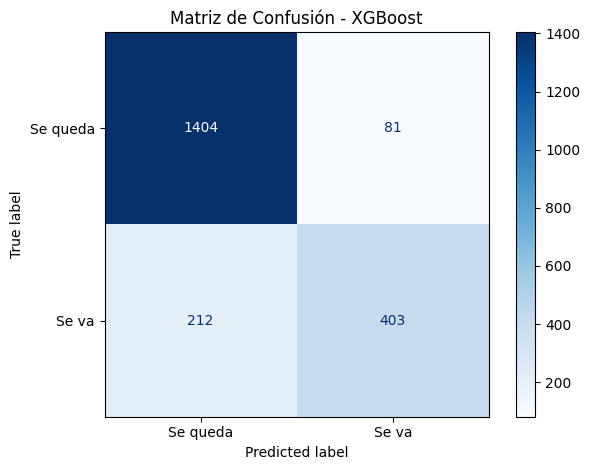

In [111]:
plot_confusion_matrix(y_test, y_pred_xgb, title="Matriz de Confusión - XGBoost")

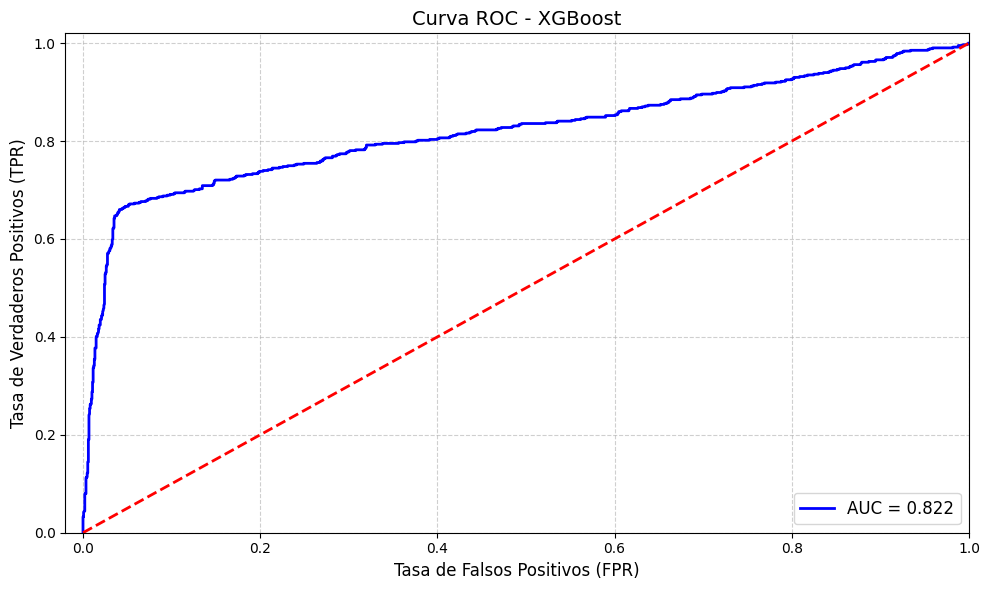

Roc-score: 82.16145191754947


In [104]:
plot_roc_curve(y_test, y_proba_xgb, title="Curva ROC - XGBoost")
print(f"Roc-score: {roc_auc_score(y_test, y_proba_xgb)*100}")

In [105]:
importances_xgb = xgb_model.feature_importances_
features = X_train.columns

feat_imp_xgb = pd.DataFrame({'feature': features, 'importance': importances_xgb})
feat_imp_xgb = feat_imp_xgb.sort_values(by='importance', ascending=False)

print(feat_imp_xgb.head(10))

                 feature  importance
4     time_spend_company    0.183295
0     satisfaction_level    0.159022
2         number_project    0.108582
1        last_evaluation    0.051414
3   average_montly_hours    0.046232
13              sales_hr    0.040799
14      sales_management    0.036574
11           sales_RandD    0.034363
19       sales_technical    0.031594
16     sales_product_mng    0.031224


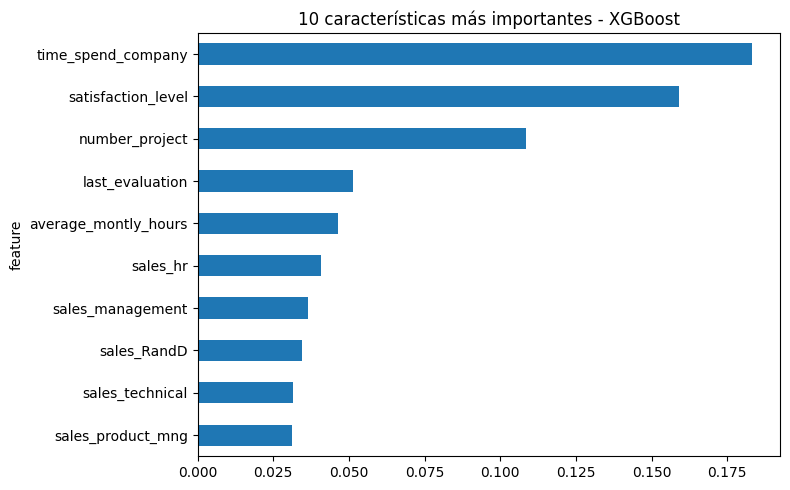

In [106]:
feat_imp_xgb.head(10).plot(kind='barh', x='feature', y='importance', legend=False, figsize=(8,5))
plt.title("10 características más importantes - XGBoost")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Análisis XGBoost

se observa un buen desempeño general con una precision de 86% en la clasificación global. El modelo muestra una mayor eficiencia al predecir la clase "Se queda" (con una precisión de 0.87 y un recall de 0.95) en comparación con la clase "Se va" (con precisión de 0.83 y recall de 0.66), lo que sugiere que el modelo tiene un mejor rendimiento en identificar a los empleados que se quedan.

El F1-score para la clase "Se va" es más bajo, lo que indica un posible desbalance entre las clases o que el modelo podría mejorar en la predicción de esta categoría. En cuanto a la importancia de caracteristicas, se destaca "time_spend_company" y "satisfaction_level" como las variables más influyentes, lo que sugiere que el tiempo en la empresa y el nivel de satisfaccion son determinantes clave en la predicción de la permanencia de los empleados.

El ROC-AUC score de 82.16% indica una buena capacidad del modelo para discriminar entre las dos clases. En resumen, el modelo XGBoost muestra un desempeño solido, aunque podría beneficiarse de una mayor optimizacion, especialmente en la predicción de la clase menos representada.

## Técnicas Aplicadas
### Balanceo de clases (SMOTE)
En el conjunto de datos original, se observo un desbalance significativo en la variable objetivo left, donde aproximadamente 71% de los empleados permanecen en la compañia y pero tan solo el 29% la abandonan. Este desequilibrio puede provocar que  alguno de los modelos de clasificacion como los que usamos anteriormente tiendan a favorecer la clase mayoritaria, resultando en un rendimiento deficiente para identificar correctamente a los empleados que podrian abandonar la empresa (clase minoritaria).

Dado que el objetivo principal del modelo es predecir de forma efectiva los casos de empleados que se van, es decir, maximizar el recall de la clase positiva (left = 1), se decidió aplicar una tecnica de balanceo de clases para mejorar esta capacidad predictiva.

**Técnica aplicada:**

Se utilizó SMOTE, una tecnica de sobremuestreo que genera nuevos datos sintéticos de la clase minoritaria a partir de sus vecinos más cercanos. Esto permite:

- Aumentar la representación de la clase left = 1 sin eliminar datos de la clase mayoritaria.

- Evitar el sobreajuste que podría presentarse al duplicar directamente instancias.

- Mejorar la capacidad del modelo para aprender patrones relevantes en ambas clases de forma equilibrada.

**Reentrenamiento de modelos**

Tras aplicar SMOTE al conjunto de entrenamiento, se procederá a reentrenar todos los modelos de clasificacin (MLP, SVM, Random Forest, y XGBoost) sobre este nuevo conjunto de datos balanceado. Esto permite comparar el rendimiento de cada modelo con y sin balanceo, y evaluar si el recall en la clase positiva mejora de manera significativa. Como ya se explicaron todos los modelos anteriormente, el como funcionan, sus ventajas y desventajas, ademas de que di una pequeña conclusion de los resultados obtenidos por estos en el entrenamiento con las clases desbalanceadas al momento de entrenarlos, ahora me enfocaré en los resultados que se obtengan de estos mediante el balanceo de clases para el entrenamiento de los mismos con el fin de observer si realmente aportar una mejora significativa a estos modelos para poder elegir el mejor, con mayores y mejores argumentos a su favor.

**Modificacion del umbral de clasificacion**

En caso tal y ninguno de los modelos logren los resultados esperados (un recall > 75%). Aplicaré como ultima medida, aplicarle un umbral favoreciendo la clase minoritaria, con el fin de conseguir un mejor recall. Con el objetivo de que el modelo sea más sensible a detectar empleados en riesgo de irse, sacrificando algo de precisión. Esto me parece util en este caso, ya que:

- El costo de perder un empleado es alto.

- Se quiere prevenir la salida de un empleado.

- La empresa prefiere tener alertas falsas (falsos positivos) antes que perder oportunidades.

In [21]:
def evaluar_umbral(modelo, X_test_scaled, y_test, nombre_modelo="Modelo", umbral=0.5):
    y_proba = modelo.predict_proba(X_test_scaled)[:, 1]
    y_pred_custom = (y_proba >= umbral).astype(int)
    
    print(f"Reporte de Clasificación - {nombre_modelo} (Umbral = {umbral}):")
    print(classification_report(y_test, y_pred_custom))
    
    plot_confusion_matrix(y_test, y_pred_custom, title=f"Matriz de Confusión - {nombre_modelo} (Umbral = {umbral})")
    
    plot_roc_curve(y_test, y_proba, title=f"Curva ROC - {nombre_modelo} (Umbral = {umbral})")
    
    auc_score = roc_auc_score(y_test, y_proba)
    print(f"AUC-ROC: {auc_score*100}")
    
    return {
        "modelo": nombre_modelo,
        "umbral": umbral,
        "auc": auc_score,
        "y_pred": y_pred_custom,
        "y_proba": y_proba
    }

In [22]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train) #aplicamos SMOTE sobre los datos escalados

print("Antes de SMOTE:\n", y_train.value_counts())
print("Despues de SMOTE:\n", pd.Series(y_train_smote).value_counts())

print("\nDimensiones de X_train:", X_train.shape)
print("Dimensiones de X_train_smote:", X_train_smote.shape)

Antes de SMOTE:
 left
0    5939
1    2460
Name: count, dtype: int64
Despues de SMOTE:
 left
0    5939
1    5939
Name: count, dtype: int64

Dimensiones de X_train: (8399, 20)
Dimensiones de X_train_smote: (11878, 20)


#### Random Forest

In [27]:
param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5],
}

rf = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring='recall',
    cv=10,
    verbose=2,
    n_jobs=-1
)

grid_search_rf.fit(X_train_smote, y_train_smote)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, None],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='recall', verbose=2)

In [28]:
best_params_rf = grid_search_rf.best_params_
print("Mejor configuracion Random Forest:", best_params_rf)

final_rf = RandomForestClassifier(
    random_state=42,
    **best_params_rf
)

final_rf.fit(X_train_smote, y_train_smote)

y_pred_rf = final_rf.predict(X_test_scaled)
y_proba_rf = final_rf.predict_proba(X_test_scaled)[:, 1]

Mejor configuracion Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [29]:
print("Reporte Random Forest (Balanceado):\n", classification_report(y_test, y_pred_rf))

Reporte Random Forest (Balanceado):
               precision    recall  f1-score   support

           0       0.87      0.95      0.91      1485
           1       0.84      0.65      0.73       615

    accuracy                           0.86      2100
   macro avg       0.85      0.80      0.82      2100
weighted avg       0.86      0.86      0.86      2100



<Figure size 1000x600 with 0 Axes>

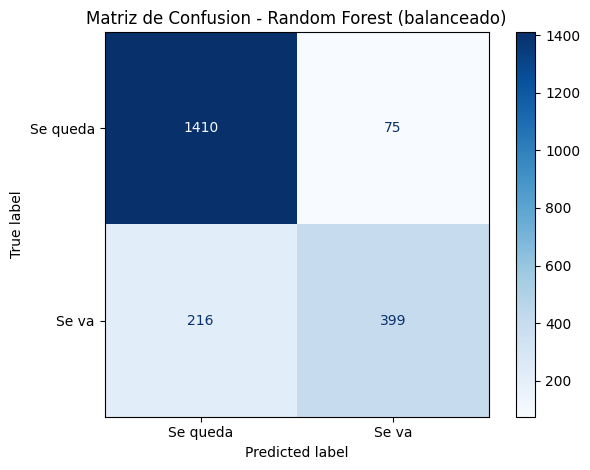

In [30]:
plot_confusion_matrix(y_test, y_pred_rf, title="Matriz de Confusion - Random Forest (balanceado)")

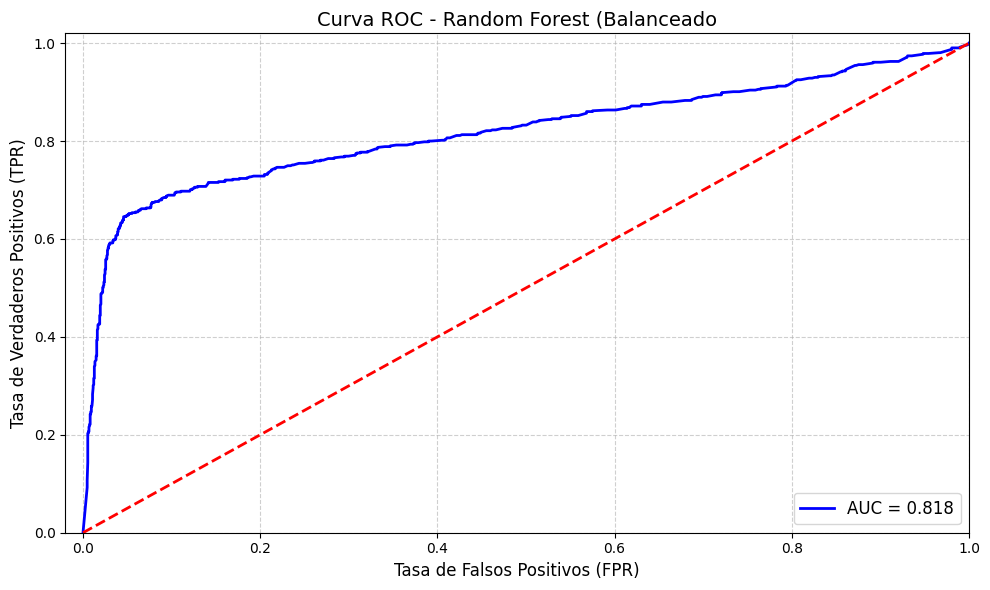

AUC-ROC: 81.83909556267281


In [31]:
plot_roc_curve(y_test, y_proba_rf, title="Curva ROC - Random Forest (Balanceado")
print("AUC-ROC:", roc_auc_score(y_test, y_proba_rf)*100)

**Ajustando el umbral**

Reporte de Clasificación - Random Forest (Umbral = 0.4):
              precision    recall  f1-score   support

           0       0.87      0.92      0.90      1485
           1       0.78      0.66      0.72       615

    accuracy                           0.85      2100
   macro avg       0.83      0.79      0.81      2100
weighted avg       0.84      0.85      0.84      2100



<Figure size 1000x600 with 0 Axes>

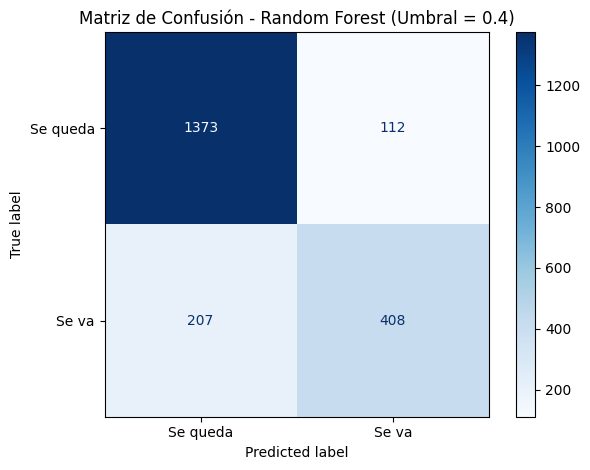

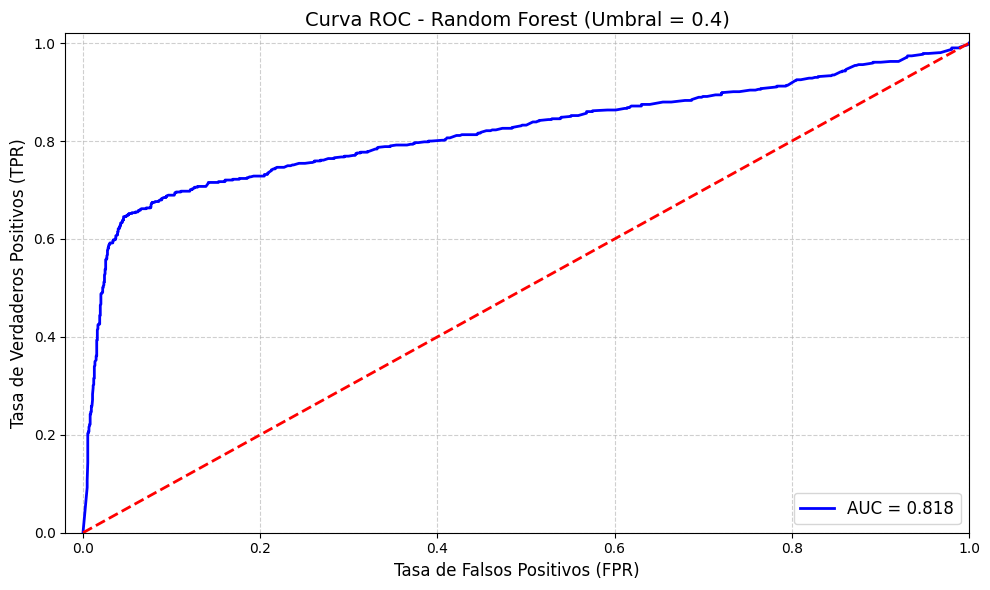

AUC-ROC: 81.83909556267281


In [41]:
model_rf_umbral = evaluar_umbral(final_rf, X_test_scaled, y_test,  "Random Forest", umbral=0.40)

#### MLP


In [42]:
param_grid = {
    "hidden_layer_sizes": [
        (5,), (10,), (15,), (5, 5), (10, 5), (10, 10),
        (20, 20), (30, 30), (50, 50), (100, 100),
        (50, 25), (100, 50), (30, 20), (20, 10)
    ]
}

mlp = MLPClassifier(max_iter=10000, random_state=42)

grid_search_mlp = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    scoring='recall',
    cv=10,
    return_train_score=True,
    verbose=True,
    n_jobs=-1
)

grid_search_mlp.fit(X_train_smote, y_train_smote)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


GridSearchCV(cv=10, estimator=MLPClassifier(max_iter=10000, random_state=42),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(5,), (10,), (15,), (5, 5),
                                                (10, 5), (10, 10), (20, 20),
                                                (30, 30), (50, 50), (100, 100),
                                                (50, 25), (100, 50), (30, 20),
                                                (20, 10)]},
             return_train_score=True, scoring='recall', verbose=True)

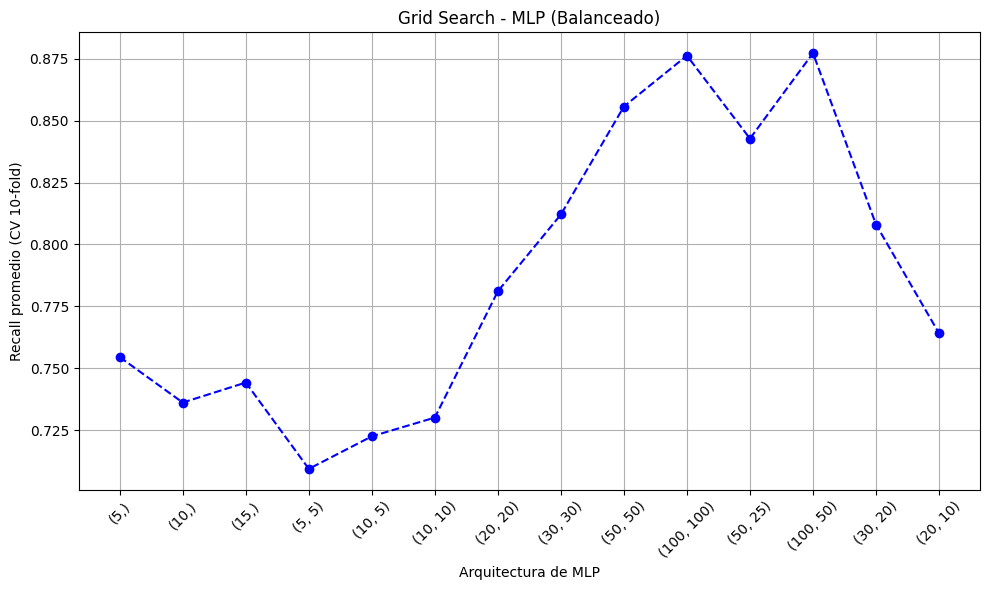

Mejor configuracion (Balanceado): {'hidden_layer_sizes': (100, 50)}
Mejor recall promedio: 0.8772676171495732


In [69]:
results_mlp = pd.DataFrame(grid_search_mlp.cv_results_)

plt.figure(figsize=(10, 6))
plt.plot(results_mlp['param_hidden_layer_sizes'].astype(str),
         results_mlp['mean_test_score'], marker='o', linestyle='--', color='blue')
plt.xlabel("Arquitectura de MLP")
plt.ylabel("Recall promedio (CV 10-fold)")
plt.title("Grid Search - MLP (Balanceado)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

best_hidden_ly = grid_search_mlp.best_params_
print("Mejor configuracion (Balanceado):", best_hidden_ly)
print("Mejor recall promedio:", grid_search_mlp.best_score_)

In [44]:
final_mlp = MLPClassifier(
    hidden_layer_sizes=best_hidden_ly['hidden_layer_sizes'],
    max_iter=10000,
    random_state=42
)

final_mlp.fit(X_train_smote, y_train_smote)

MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=10000, random_state=42)

In [45]:
y_pred_mlp = final_mlp.predict(X_test_scaled)
y_proba_mlp = final_mlp.predict_proba(X_test_scaled)[:, 1]

print("Reporte de Clasificación MLP (Balanceado):\n", classification_report(y_test, y_pred_mlp))

Reporte de Clasificación MLP (Balanceado):
               precision    recall  f1-score   support

           0       0.87      0.83      0.85      1485
           1       0.63      0.70      0.66       615

    accuracy                           0.79      2100
   macro avg       0.75      0.76      0.75      2100
weighted avg       0.80      0.79      0.79      2100



<Figure size 1000x600 with 0 Axes>

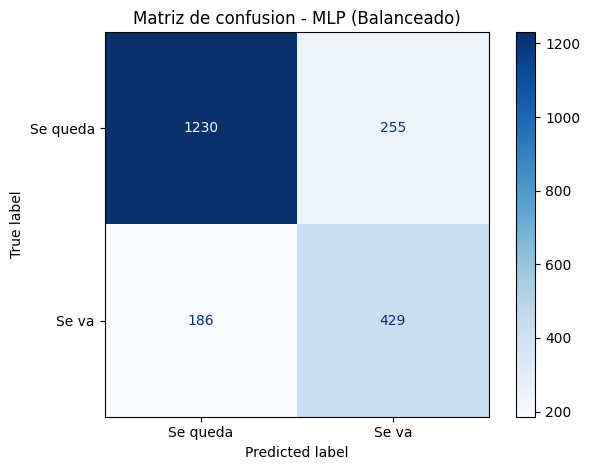

In [46]:
plot_confusion_matrix(y_test, y_pred_mlp, title="Matriz de confusion - MLP (Balanceado)")

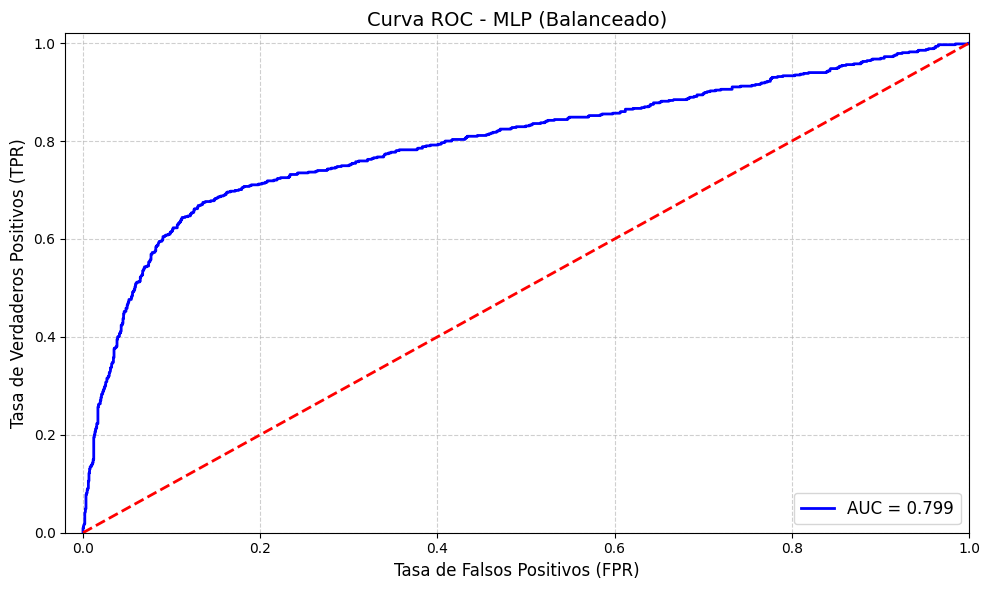

AUC-score: 79.86674331389779


In [47]:
plot_roc_curve(y_test, y_proba_mlp, title="Curva ROC - MLP (Balanceado)")
print(f"AUC-score: {roc_auc_score(y_test, y_proba_mlp)*100}")

**Ajustando el umbral**

Reporte de Clasificación - MLP (Umbral = 0.4):
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1485
           1       0.59      0.71      0.65       615

    accuracy                           0.77      2100
   macro avg       0.73      0.76      0.74      2100
weighted avg       0.79      0.77      0.78      2100



<Figure size 1000x600 with 0 Axes>

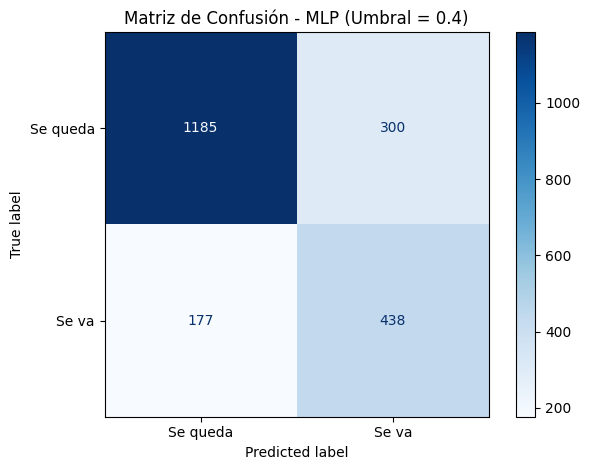

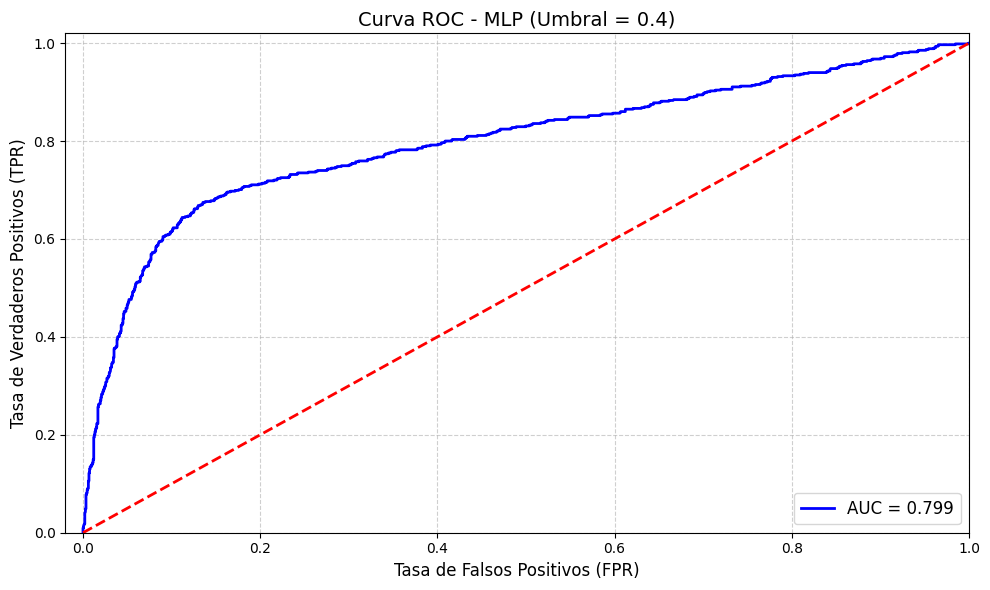

AUC-ROC: 79.86674331389779


In [48]:
model_mlp_umbral = evaluar_umbral(final_mlp, X_test_scaled, y_test, "MLP", umbral=0.40)

#### SVM

In [34]:
param_grid_svm = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"]
}

svm = SVC(probability=True, random_state=42)

grid_search_svm = GridSearchCV(
    estimator=svm,
    param_grid=param_grid_svm,
    scoring='recall',
    cv=10,
    return_train_score=True,
    verbose=2,
    n_jobs=-1
)

In [35]:
grid_search_svm.fit(X_train_smote, y_train_smote)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 2.2min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 1.8min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 1.7min
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time= 1.7min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time= 1.7min
[CV] END ....................C=1, gamma=scale, kernel=linear; total time= 2.4min
[CV] END ....................C=1, gamma=scale, kernel=linear; total time= 2.7min
[CV] END .....................C=1, gamma=auto, kernel=linear; total time= 2.5min
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time= 1.5min
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time= 1.4min
[CV] END ...................C=10, gamma=scale, kernel=linear; total time= 4.4min
[CV] END ......................C=10, gamma=sca

GridSearchCV(cv=10, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             return_train_score=True, scoring='recall', verbose=2)

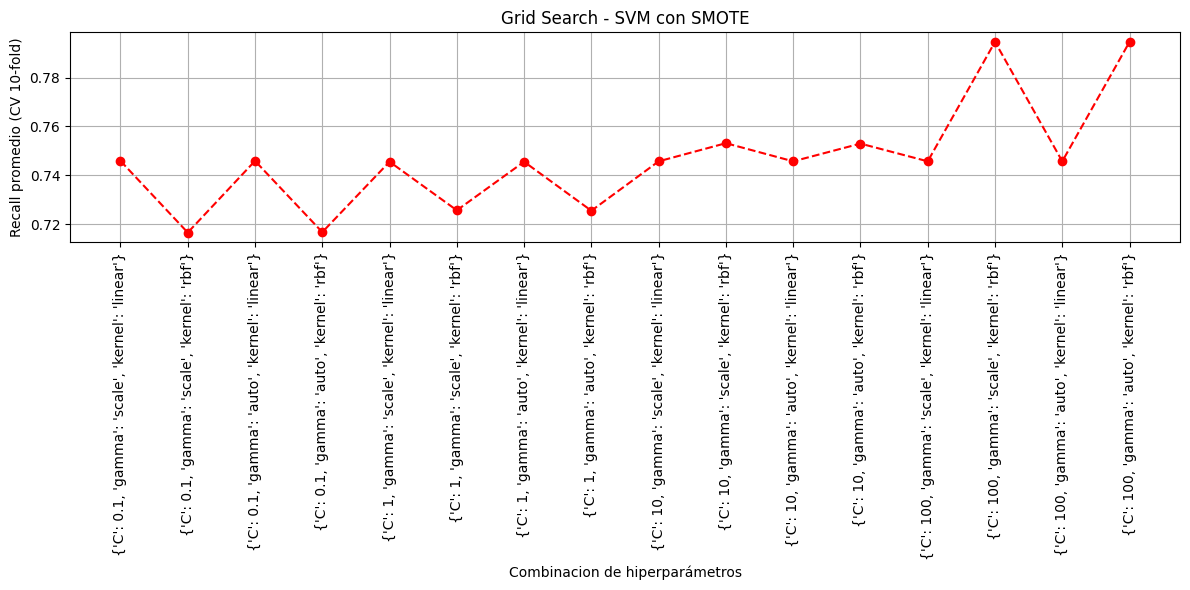

Mejor configuracion (SVM + SMOTE): {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor recall promedio: 0.794588379579948


In [89]:
results_svm = pd.DataFrame(grid_search_svm.cv_results_)

plt.figure(figsize=(12, 6))
plt.plot(results_svm['params'].astype(str),
         results_svm['mean_test_score'], marker='o', linestyle='--', color='red')
plt.xlabel("Combinacion de hiperparámetros")
plt.ylabel("Recall promedio (CV 10-fold)")
plt.title("Grid Search - SVM con SMOTE")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

best_params_svm = grid_search_svm.best_params_
print("Mejor configuracion (SVM + SMOTE):", best_params_svm)
print("Mejor recall promedio:", grid_search_svm.best_score_)

In [37]:
final_svm = SVC(
    probability=True,
    C=best_params_svm['C'],
    kernel=best_params_svm['kernel'],
    gamma=best_params_svm['gamma'],
    random_state=42
)

final_svm.fit(X_train_smote, y_train_smote)

SVC(C=100, probability=True, random_state=42)

In [119]:
y_pred_svm = final_svm.predict(X_test_scaled)
y_proba_svm = final_svm.predict_proba(X_test_scaled)[:, 1]

In [90]:
print("Reporte de Clasificacion - SVM (Balanceado):\n", classification_report(y_test, y_pred_svm))

Reporte de Clasificacion - SVM (Balanceado):
               precision    recall  f1-score   support

           0       0.87      0.89      0.88      1485
           1       0.72      0.69      0.70       615

    accuracy                           0.83      2100
   macro avg       0.79      0.79      0.79      2100
weighted avg       0.83      0.83      0.83      2100



<Figure size 1000x600 with 0 Axes>

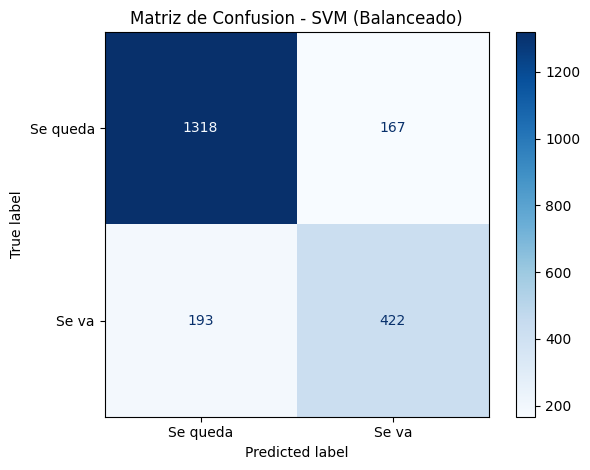

In [75]:
plot_confusion_matrix(y_test, y_pred_svm, title="Matriz de Confusion - SVM (Balanceado)")

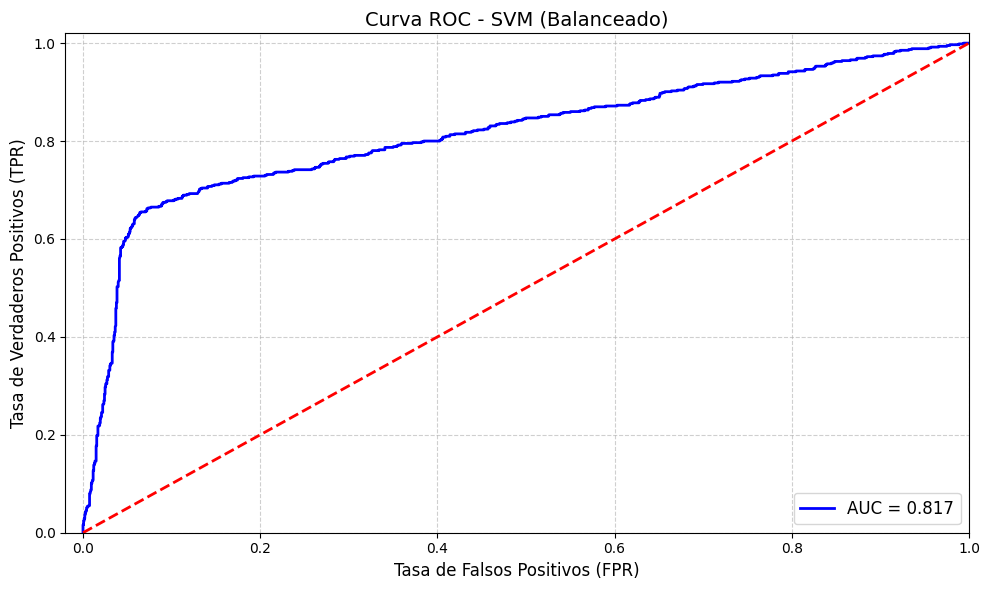

AUC-ROC: 81.69127590265803


In [76]:
plot_roc_curve(y_test, y_proba_svm, title="Curva ROC - SVM (Balanceado)")
print("AUC-ROC:", roc_auc_score(y_test, y_proba_svm)*100)

**Ajustando el umbral**


Reporte de Clasificación - SVM (Umbral = 0.4):
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1485
           1       0.63      0.72      0.67       615

    accuracy                           0.79      2100
   macro avg       0.75      0.77      0.76      2100
weighted avg       0.81      0.79      0.80      2100



<Figure size 1000x600 with 0 Axes>

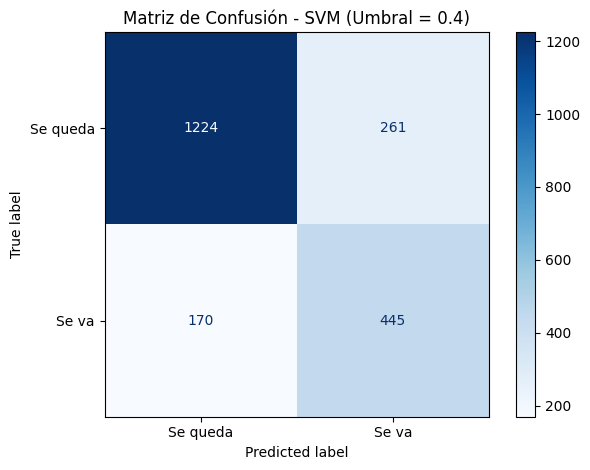

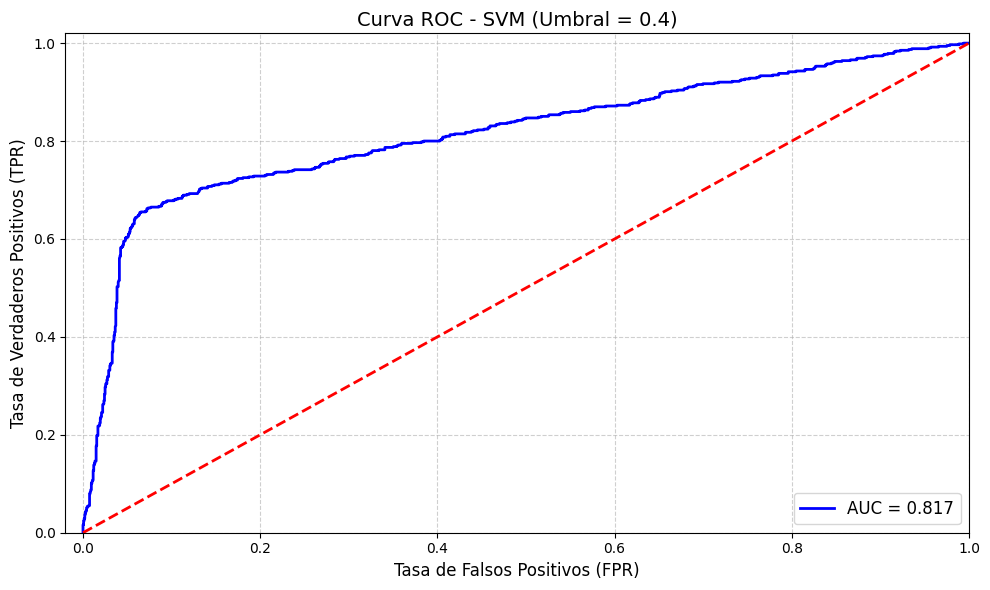

AUC-ROC: 81.69127590265803


In [32]:
model_svm_umbral = evaluar_umbral(final_svm, X_test_scaled, y_test, "SVM", umbral=0.4)

  0%|          | 0/100 [00:00<?, ?it/s]

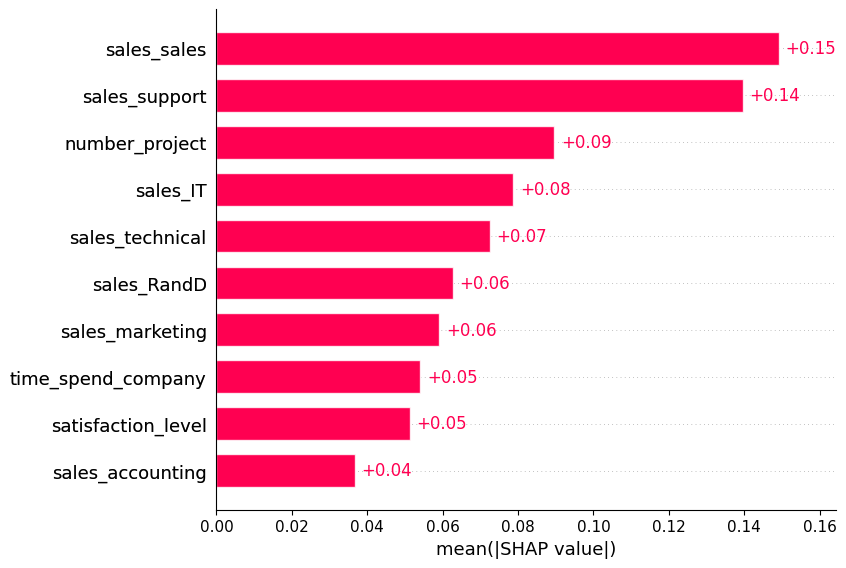

In [45]:
X_test_sample = shap.sample(X_test_scaled, 100, random_state=42)
X_test_sample_df = pd.DataFrame(X_test_sample, columns=X.columns)
X_background = shap.sample(X_train_scaled, 50, random_state=42)

explainer_svm = shap.KernelExplainer(final_svm.predict, X_background)

shap_values_svm = explainer_svm.shap_values(X_test_sample)
mean_abs_shap_svm = np.abs(shap_values_svm).mean(axis=0)
top_10_idx_svm = np.argsort(mean_abs_shap_svm)[-10:]

shap_explanation_svm_top10 = shap.Explanation(
    values=shap_values_svm[:, top_10_idx_svm],
    data=X_test_sample_df.values[:, top_10_idx_svm],
    feature_names=[X.columns[i] for i in top_10_idx_svm]
)

shap.plots.bar(shap_explanation_svm_top10)

#### Gradient Boosting

In [55]:
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train_smote, y_train_smote)

y_pred_gbc = gbc.predict(X_test_scaled)
y_proba_gbc = gbc.predict_proba(X_test_scaled)[:, 1]

In [56]:
print("Reporte de Clasificacion - Gradient Boosting (Balanceado):\n")
print(classification_report(y_test, y_pred_gbc))

Reporte de Clasificacion - Gradient Boosting (Balanceado):

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1485
           1       0.82      0.66      0.73       615

    accuracy                           0.86      2100
   macro avg       0.84      0.80      0.82      2100
weighted avg       0.85      0.86      0.85      2100



<Figure size 1000x600 with 0 Axes>

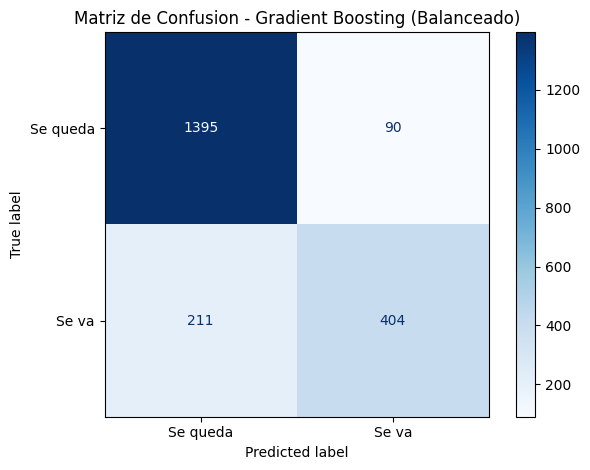

In [57]:
plot_confusion_matrix(y_test, y_pred_gbc, title="Matriz de Confusion - Gradient Boosting (Balanceado)")

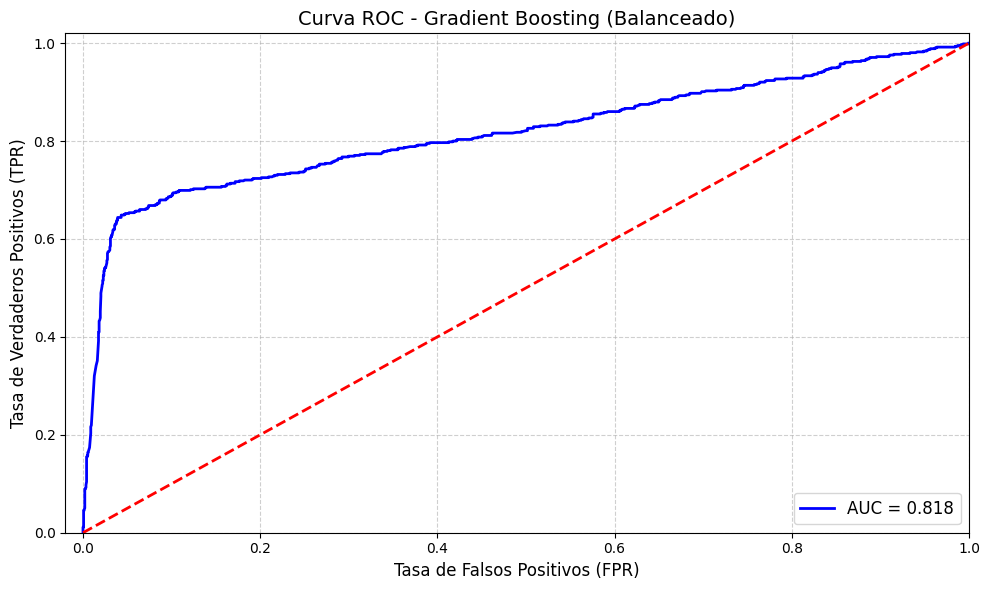

AUC-ROC: 81.75538583668664


In [58]:
plot_roc_curve(y_test, y_proba_gbc, title="Curva ROC - Gradient Boosting (Balanceado)")
print("AUC-ROC:", roc_auc_score(y_test, y_proba_gbc)*100)

**Ajustando el umbral**

Reporte de Clasificación - Gradient Boosting (Umbral = 0.4):
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1485
           1       0.76      0.67      0.72       615

    accuracy                           0.84      2100
   macro avg       0.82      0.79      0.80      2100
weighted avg       0.84      0.84      0.84      2100



<Figure size 1000x600 with 0 Axes>

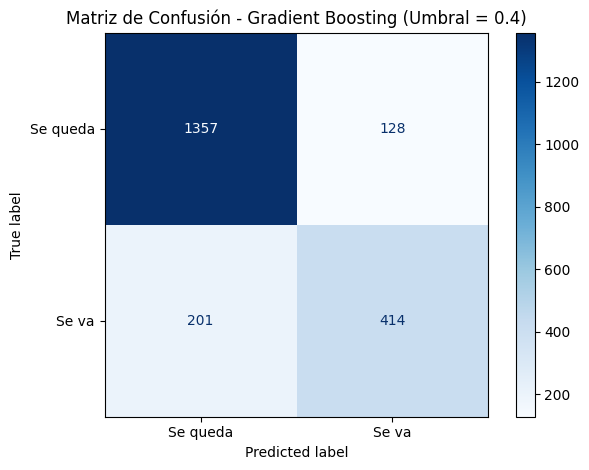

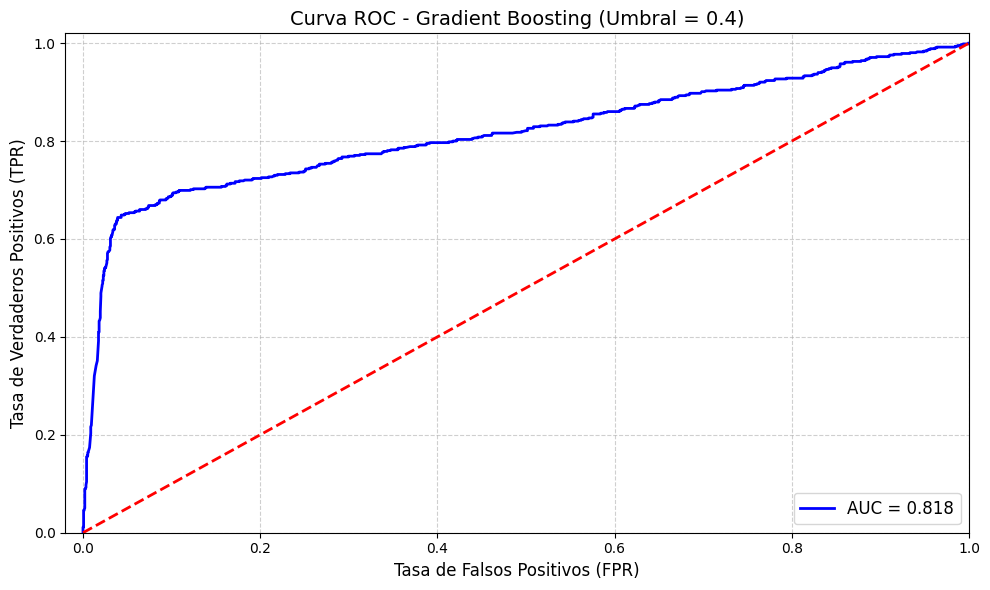

AUC-ROC: 81.75538583668664


In [70]:
model_gdc_umbral = evaluar_umbral(gbc, X_test_scaled, y_test, "Gradient Boosting", umbral=0.40)

#### XGBoost 

In [33]:
param_grid_xgb = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2]
}

xgb = XGBClassifier( eval_metric='logloss', random_state=42)

grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring='recall',
    cv=10,
    verbose=2,
    n_jobs=-1
)

grid_search_xgb.fit(X_train_smote, y_train_smote)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constrain...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200]},
             scoring='recall', verbose=2)

In [34]:
best_params_xgb = grid_search_xgb.best_params_
print("Mejor configuración XGBoost:", best_params_xgb)

Mejor configuración XGBoost: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}


In [35]:
final_xgb = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    **best_params_xgb
)

final_xgb.fit(X_train_smote, y_train_smote)

y_pred_xgb = final_xgb.predict(X_test_scaled)
y_proba_xgb = final_xgb.predict_proba(X_test_scaled)[:, 1]

In [36]:
print("Reporte de Clasificacion - XGBoost (Balanceado):\n", classification_report(y_test, y_pred_xgb))

Reporte de Clasificacion - XGBoost (Balanceado):
               precision    recall  f1-score   support

           0       0.87      0.94      0.90      1485
           1       0.82      0.66      0.73       615

    accuracy                           0.86      2100
   macro avg       0.85      0.80      0.82      2100
weighted avg       0.86      0.86      0.85      2100



<Figure size 1000x600 with 0 Axes>

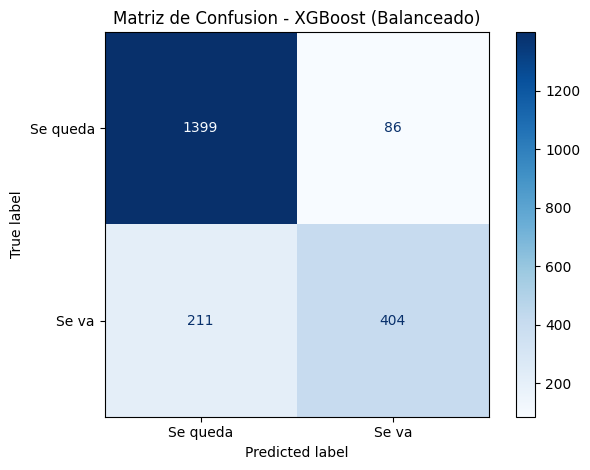

In [37]:
plot_confusion_matrix(y_test, y_pred_xgb, title="Matriz de Confusion - XGBoost (Balanceado)")

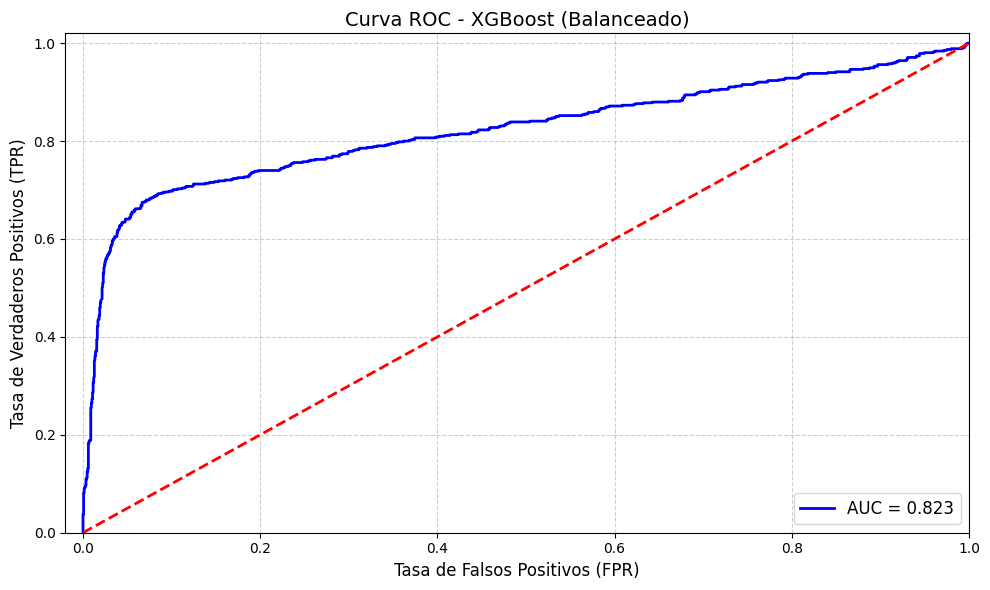

AUC-ROC: 82.25518053160329


In [38]:
plot_roc_curve(y_test, y_proba_xgb, title="Curva ROC - XGBoost (Balanceado)")
print("AUC-ROC:", roc_auc_score(y_test, y_proba_xgb)*100)

**Ajustando el umbral**

Reporte de Clasificación - XGBoost (Umbral = 0.4):
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1485
           1       0.78      0.68      0.73       615

    accuracy                           0.85      2100
   macro avg       0.83      0.80      0.81      2100
weighted avg       0.85      0.85      0.85      2100



<Figure size 1000x600 with 0 Axes>

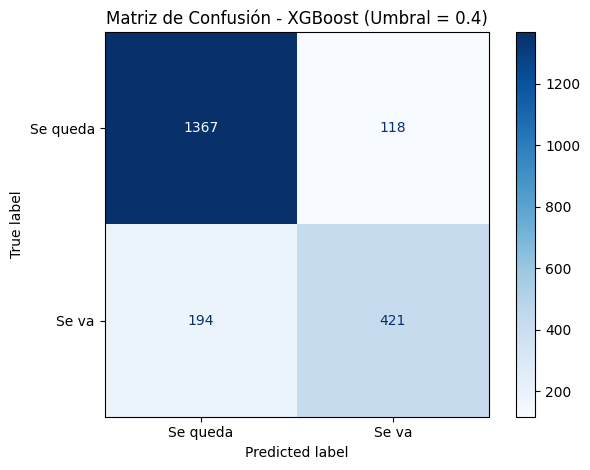

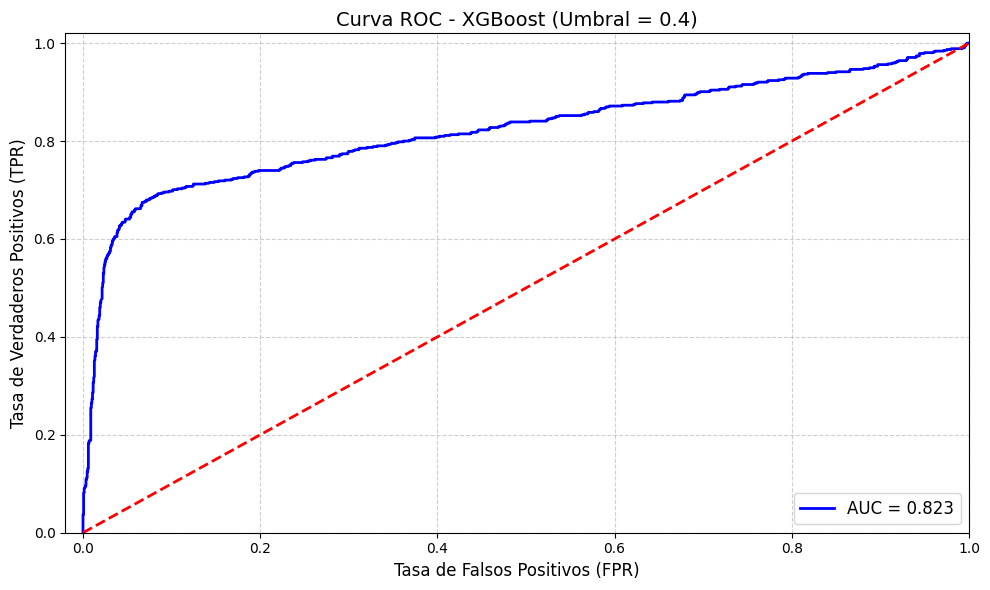

AUC-ROC: 82.25518053160329


In [39]:
model_xgb_umbral = evaluar_umbral(final_xgb, X_test_scaled, y_test, "XGBoost", umbral=0.40)

 95%|=================== | 1989/2100 [00:15<00:00]       

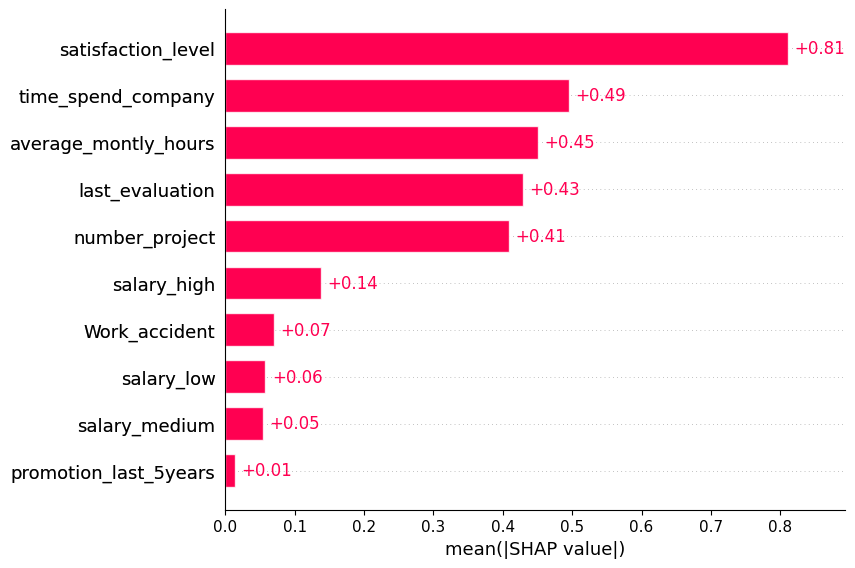

In [40]:
explainer_xgb = shap.Explainer(final_xgb, X_background)
shap_values_xgb = explainer_xgb(X_test_scaled)

shap_values_xgb.feature_names = X.columns.tolist()

shap.plots.bar(shap_values_xgb[:, :10])

# Informe Final – Clasificación de  Empleados

## Objetivo del proyecto 
Este proyecto tiene como finalidad desarrollar un clasificador que permita al area de Recursos Humanos predecir con anticipacion si un empleado está en riesgo de abandonar la compañía, de modo que se puedan implementar acciones preventivas para su retención. Las variables categoricas fueron transformadas mediante **One-Hot Encoding**. Se realizó análisis exploratorio, preprocesamiento y escalado cuando fue necesario, el dataset contaba con la variable **left**, la cual era la variable objetivo (1 = se fue, 0 = se quedó).

Dado que el objetivo principal es detectar a los empleados en riesgo (clase 1), se priorizó el uso de métricas como:

- Recall (clase 1): para minimizar falsos negativos (empleados que se van y no son detectados).

- F1-score: balance entre precisión y recall.

- AUC-ROC: capacidad general del modelo para distinguir entre clases.

## Modelos Evaluados

Se entrenaron y compararon cinco modelos, a los cuales se les entreno con el dataset original (desbalance de clases), se les aplicó una tecnica para balanceo de clases y se reentrenaron los modelos con el nuevo dataset balanceado. Ademas, se propuso el uso de ajustar el umbral en todos tus modelos con el fin de poderle sacar mejor rendimiento, ya que esta es una tecnica potente y práctica que me parecio util aplicar en este contexto, los resultados de la misma estan en la segunda tabla.

## Resultados


| Modelo          | Dataset     | Recall (Clase 1) | Precision (Clase 1) | F1-score (Clase 1) | AUC-ROC |
|-----------------|-------------|------------------|---------------------|--------------------|---------|
| Random Forest   | Original    | 0.64             | 0.86                | 0.73               | 82.02   |
| Random Forest   | Balanceado  | 0.65             | 0.84                | 0.73               | 81.84   |
| SVM             | Original    | 0.67             | 0.77                | 0.72               | 81.70   |
| SVM             | Balanceado  | 0.69             | 0.72                | 0.70               | 81.69   |
| MLP             | Original    | 0.67             | 0.74                | 0.70               | 81.26   |
| MLP             | Balanceado  | 0.70             | 0.63                | 0.66               | 79.87   |
| Gradient Boost  | Original    | 0.65             | 0.86                | 0.74               | 81.59   |
|Gradient Boost   |	Balanceado  | 0.66	           |0.82	             | 0.73	              | 81.76   |
| XGBoost         | Original    | 0.68             | 0.82                | 0.74               | 82.41   |
| XGBoost         | Balanceado  | 0.66             | 0.82                | 0.73               | 82.26   |

Los modelos entrenados con balanceo de clases mediante SMOTE lograron mejoras leves en el recall de la clase minoritaria (se va) en la mayoría de los casos. Sin embargo, estas mejoras generaron mejores resultados en general. Modelos como XGBoost, Random Forest y Gradient Boosting mantuvieron una alta estabilidad con o sin balanceo, reflejando su robustez frente al desbalance. El MLP, aunque aumentó su recall al ser balanceado, pero a su vez perdio demasiada precision y disminuyo su F1-score, evidenciando mayor sensibilidad al tipo de distribucion. Pero a nivel general, los modelos balanceados permitieron un mejor aprendizaje de la clase minoritaria, pero sin mejoras significativas, lo que sugiere que el balanceo es util, pero no suficiente por si solo.

## Umbral 0.4

| Modelo              | Recall (Se va) | Precision (Se va) | F1-score (Se va) | AUC-ROC | Falsos Positivos | Falsos Negativos |
|---------------------|----------------|-------------------|------------------|---------|------------------|------------------|
| Random Forest       | 0.66           | 0.78              | 0.72             | 81.84   | 112              | 207              |
| MLP                 | 0.71           | 0.59              | 0.65             | 79.87   | 300              | 177              |
| SVM                 | 0.72           | 0.63              | 0.67             | 81.70   | 261              | 170              |
| Gradient Boosting   | 0.67           | 0.76              | 0.72             | 81.76   | 128              | 201              |
| XGBoost             | 0.68           | 0.78              | 0.73             | 82.26   | 118              | 194              |


El ajuste del umbral de decision para cada uno de los modelos a **0.4** permitió aumentar el recall en todos los modelos, mejorando su capacidad para detectar empleados que podrian abandonar la empresa. Este cambio genero un mayor numero de verdaderos positivos, aunque a costa de un aumento en los falsos positivos. Modelos como SVM y MLP mostraron un incremento claro en el recall (hasta 0.72 y 0.71, respectivamente), pero con una disminución en la precisión. Por otro lado, XGBoost y Gradient Boosting lograron mantener un balance optimo, con alta precisión (0.78 y 0.76) y F1-score sólidos (0.73 y 0.72). Este ajuste demuestra ser una técnica efectiva para priorizar la sensibilidad del modelo cuando se busca prevenir la rotacion, aunque esto conlleve sacrificar algo de exactitud en las predicciones.


### Conclusión Final


El presente proyecto evaluó múltiples modelos de clasificación para predecir la probabilidad de que un empleado abandone la compañía, con el fin de facilitar al departamento de Recursos Humanos la implementación de estrategias proactivas de retención.</p>

Se entrenaron y compararon cinco modelos principales: Random Forest, SVM, MLP, Gradient Boosting y XGBoost, utilizando técnicas como balanceo de clases con SMOTE y ajuste del umbral de decisión (threshold). Las métricas clave fueron el recall de la clase positiva (empleados que se van), precisión, F1-score y AUC-ROC, enfocándonos especialmente en maximizar el recall sin sacrificar de forma excesiva la precisión, debido a la prioridad de detectar correctamente a los empleados en riesgo de salida.

### Modelo Recomendado: XGBoost (umbral 0.4)

Tras un análisis exhaustivo, el modelo XGBoost con ajuste de umbral a 0.4 es el que mejor se adapta al objetivo del proyecto, por las siguientes razones:

**Ventajas**:

- Excelente equilibrio entre recall (0.68) y precisión (0.78): Detecta una alta proporción de empleados en riesgo con bajo nivel de falsas alarmas.

- Mejor F1-score general (0.73), lo que indica una adecuada armonía entre sensibilidad y exactitud.

- Mayor AUC-ROC (82.26) entre todos los modelos, lo que refleja una muy buena capacidad discriminativa entre ambas clases.

- Alta estabilidad: su rendimiento se mantuvo sólido tanto con datos originales, balanceados y tras ajustar el umbral.

**Desventajas:**

- Ligera pérdida de recall frente a SVM (0.72 vs. 0.68), aunque con mejor precisión, lo que resulta más equilibrado para una aplicación práctica.

- Requiere un poco más de tiempo de entrenamiento y recursos computacionales, aunque esto es manejable para el tamaño actual del dataset.


¿Por qué XGBoost es el más adecuado para RRHH?

El objetivo principal es detectar proactivamente a empleados en riesgo de irse para tomar medidas preventivas. En este contexto, el modelo debe:

- Tener un alto recall (para no pasar por alto a los que se van).

- Mantener una precisión razonable (para no generar demasiadas falsas alertas).

- Ser estable, confiable y fácil de explicar.

XGBoost cumple con todos estos requisitos: permite identificar de manera confiable a la mayoría de los empleados que podrían irse, sin embargo, aunque puede generar algunas falsas alarmas, lo hace manteniendo un nivel de precision que lo vuelve confiable para uso práctico.

**Conclusión final:**

XGBoost con umbral ajustado a 0.4 es el modelo más recomendable para ser implementado en el sistema de alertas del área de Recursos Humanos, permitiendo un balance óptimo entre detección temprana, precisión operativa y robustez predictiva. Pero, debido a que este modelo fue un plus, o algo que agregue por mi cuenta y no estoy seguro si se haya visto en el curso, daré otro modelo como alternativa, con el fin de que se puedan obtener dos cosas: Primero, se tenga otra opcion en caso de que este modelo falle o no pueda predecir tan bien. Segundo, la eleccion de un modelo que haya sido explicado en el curso y con el cual se obtengan muy buenos resultados igualmente.


### Segunda Opción Recomendada: SVM (umbral 0.4)

El modelo SVM con umbral ajustado a 0.4 es la segunda mejor alternativa para este caso de uso. Aunque ligeramente por debajo de XGBoost en AUC y F1-score, su desempeño general lo hace altamente competitivo y útil en un entorno donde la prioridad es detectar al máximo los posibles casos de salida en el entorno laboral.

**Ventajas**:

- Mayor recall (0.72) que todos los modelos, incluyendo XGBoost, lo que significa que detecta más empleados en riesgo de irse, algo esencial para actuar preventivamente.

- F1-score sólido (0.67): buen equilibrio entre precision y sensibilidad.

- Consistente con o sin balanceo, lo cual indica una buena capacidad de generalizacion.

- Menor cantidad de falsos negativos (170): esto reduce el riesgo de que un empleado se vaya sin que el sistema lo haya advertido.

**Desventajas:**

- Menor precisión (0.63) en comparación con XGBoost, lo que genera un número mayor de falsas alertas (261), lo cual puede implicar mayor carga para el equipo de RRHH, pero a su vez, quizas pueda ser util para actual de manera temprana.

- Algo menos interpretativo si lo comparamos con modelos como árboles o como Random Forest o XGBoost, aunque sigue siendo manejable si se complementa con análisis SHAP (como se hizo en la primera parte).


SVM es especialmente recomendable si el objetivo prioriza el recall por encima de todo. Es decir, si la empresa prefiere equivocarse algunas veces (falsos positivos) pero no dejar ir a nadie sin advertencia, este modelo es ideal, esa es la razón principal por la cual lo eligiria. Tambien, este puede servir como parte de un sistema de doble validación junto a XGBoost o como un doble filtro de retención, esto tambien podria ser algo a tener en cuenta.

**Conclusión:**

SVM con umbral ajustado a 0.4 es una excelente segunda opción si se prioriza detectar la mayor cantidad de casos de rotación posibles, aceptando un numero mayor de falsas alarmas a cambio de reducir el riesgo de fuga no anticipada.

## Análisis de Importancia de Variables 

Una parte estudio fue identificar cuales variables tienen mayor impacto en la prediccion de si un empleado se irá de la compañia. Esto me parece que es relevante para RRHH, ya que permite focalizar los esfuerzos en los factores mas determinantes.

### XGBoost - SHAP

El modelo XGBoost muestra un conjunto claro de variables dominantes, con un fuerte enfoque en métricas de desempeño y experiencia del empleado:

| Variable                | Importancia SHAP | Interpretación clave                                       |
|-------------------------|------------------|------------------------------------------------------------|
| satisfaction_level    | **0.81**         | La insatisfacción es el factor más fuerte asociado a la salida. |
| time_spend_company    | 0.49             | Más años en la empresa puede implicar estancamiento o falta de retos. |
| average_montly_hours | 0.45             | Cargas excesivas de trabajo están asociadas al abandono.   |
| last_evaluation       | 0.43             | Evaluaciones recientes pueden indicar presión o insatisfacción. |
| number_project        | 0.41             | Más proyectos pueden significar sobrecarga.                |
| salary_high           | 0.14             | Incluso empleados bien pagados pueden irse si hay otros factores. |
| Work_accident         | 0.07             | Haber sufrido un accidente se relaciona con decisiones de salida. |
| salary_low            | 0.06             | Los salarios bajos también influyen en la decisión.        |
| salary_medium         | 0.05             | Similar a los bajos, aunque con menor impacto.             |
| promotion_last_5years | 0.01             | La falta de promoción tiene impacto, aunque reducido.      |

ESto nos indica que el modelo identifica una combinacion de satisfaccion, carga laboral y antigüedad como factores críticos. RRHH deberá utilizar esto para detectar empleados con baja satisfacción, sobrecarga y largo tiempo en la compañía sin crecimiento.

### SVM - SHAP

El modelo SVM muestra un enfoque ligeramente diferente, con mayor peso en el departamento de trabajo y carga operativa:

| Variable            | Importancia SHAP | Interpretacion                                                                  |
|---------------------|------------------|---------------------------------------------------------------------------------------|
| sales_sales         | 0.15             | El area de ventas presenta el mayor riesgo de rotacion.                               |
| sales_support       | 0.14             | Tambien alto riesgo puede requerir intervenciones.                                   |
| number_project      | 0.09             | Mas proyectos implican mayor riesgo.                                                  |
| sales_IT            | 0.08             | El area de IT tambien muestra un impacto importante.                                  |
| sales_technical     | 0.07             | Influencia relevante por carga o movilidad.                                           |
| sales_RandD         | 0.06             | Similar a las areas anteriores.                                                      |
| sales_marketing     | 0.06             | Impacto en rotación visible.                                                         |
| time_spend_company  | 0.05             | Similar a XGBoost, años en la empresa es factor de riesgo.                           |
| satisfaction_level  | 0.05             | Consistente con XGBoost, aunque con menor peso.                                       |
| sales_accounting    | 0.04             | Riesgo relativo en esta area.                                                        |

El modelo destaca las diferencias entre departamentos como un factor clave. Esto permite a RRHH identificar áreas específicas con mayor riesgo de salida y diseñar políticas internas diferenciadas por equipo.

**Conclusion** 

Ambos modelos coinciden en que la satisfaccion del empleado, el tiempo en la empresa y la carga laboral (numero de proyectos, horas trabajadas) son factores fundamentales. Sin embargo, SVM añade una capa adicional al mostrar que el riesgo también depende fuertemente del departamento al que pertenece el trabajador.

En base a esto propongo que:

- Se haga un monitoreo activamente la satisfacción del personal.

- Detectar sobrecarga laboral o exceso de proyectos.

- Crear rutas de desarrollo profesional, especialmente para empleados con muchos años en la empresa.

- Analizar departamentos con alto riesgo (ventas, soporte, IT) para intervenciones especificas.

El modelo destaca las diferencias entre departamentos como un factor clave. Esto permite a RRHH identificar areas específicas con mayor riesgo de salida y tomar acciones preventivas antes de que sea demasiado tarde.

Trabajo desarollado por ***Malak Sanchez***